## 0.0 Imports

In [1]:
import sys 
sys.path.append('./modules')

from modules import ts_cross_validation
import pandas as pd
import inflection
import numpy as np
import seaborn as sns
import datetime 
from matplotlib import pyplot as plt
from scipy import stats as ss
from sklearn.preprocessing import MinMaxScaler, RobustScaler, LabelEncoder
from boruta import BorutaPy
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb
import pickle

runRandomSearch = False

## 0.1 Helper functions

In [2]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline

    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 16]
    plt.rcParams['font.size'] = 24
    #pd.options.display.max_columns = None
    #pd.options.display.max_rows = None
    sns.set()

jupyter_settings()

def crammer_v(df_ref : pd.DataFrame, feature_a : str, feature_b : str) -> float:
    
    cm = pd.crosstab(df_ref[feature_a], df_ref[feature_b]).values

    chi_2 = ss.chi2_contingency(cm)[0]
    r, k = cm.shape
    n = cm.sum()

    fator_chi2 = chi_2/n - ( ((k-1)*(r-1))/(n-1) )
    
    chi2_til = max([0, fator_chi2])
    k_til = k - ( ( (k-1)**2 ) / (n-1) )
    r_til = r - ( ( (r-1)**2 ) / (n-1) )
    
    crammer_2 = chi2_til/(min ([k_til - 1, r_til - 1]) )
    
    crammer = np.sqrt(crammer_2)
    
    return crammer

def dump_model(model, path : str):
    pickle.dump(
        model, 
        open(path, 'wb')
    )



%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


# 5.0 Preparação dos dados

**Questionamentos**

Realmente o tip de scalling (min max, robustScaller, normalizoação) afetam de alguma forma a minha distribuição? 

Lembre -se **KX - C = KX + (C'); C' = -C** OU SEJA

**TODAS ESSAS OPERAÇÕES NÃO PASSAM DE: TRANSFORMAÇÕES LINEARES**

Isso até faz sentido, não quero modificar a minha distribuição, isso é fraudar o modelo. Porém como o "modelo enxerga" essas transformaões? 

**O modelo OLHA PARA TODAS as variaveis como se estivssem dentro de um mesmo universo...**

Estudos: https://www.kaggle.com/code/discdiver/guide-to-scaling-and-standardizing

**E COMO A ESCOLHA DE DIFERENTES SCALLERS PARA DIFERENTES VARIAVEIS PODEM AFETAR O MEU MODELO**

In [77]:
df0 = pd.read_parquet('./dfs/df5_init.parquet')
df5 = df0.copy()

## 5.1 - Numercial Attributes

In [78]:
numerical = df5.select_dtypes(['float', 'int'])
numerical.head()

,store,day_of_week,sales,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,competion_since_days,competion_since_month,promo2_time_week
0,1,5,5263,1,1,1270.0,9,2008,0,31,2015,0,2015,7,31,2524,84,0
3,4,5,13995,1,1,620.0,9,2009,0,31,2015,0,2015,7,31,2159,71,0
5,6,5,5651,1,1,310.0,12,2013,0,31,2015,0,2015,7,31,607,20,0
8,9,5,8565,1,1,2030.0,8,2000,0,31,2015,0,2015,7,31,5477,182,0
9,10,5,7185,1,1,3160.0,9,2009,0,31,2015,0,2015,7,31,2159,71,0


In [79]:
numerical.columns.values.tolist()

['store',
 'day_of_week',
 'sales',
 'promo',
 'school_holiday',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'is_promo',
 'year',
 'month',
 'day',
 'competion_since_days',
 'competion_since_month',
 'promo2_time_week']

In [80]:
####################################################################
#Ciclico                                                           #
#   'day_of_week',                                                 #
#   'month',                                                       #
#   'day',                                                         #
#   'promo2_since_week',                                           #
#   'promo2_since_year',                                           #
#   'competition_open_since_month',                                #
#                                                                  #
####################################################################
#                                                                  #
# Continuo                                                         #
#   'sales',                                                       #
#   'competition_distance',                                        #
#   'competition_open_since_year',                                 #
#   'competion_since_days',                                        #
#   'year',                                                        #
#   'promo2_time_week'                                             #
                                                                   # 
####################################################################
                                                                   # 
# Categoricos                                                      #     
#   'promo',                                                       # 
#   'school_holiday',                                              # 
#   'promo2',                                                      # 
#   'is_promo',                                                    #     
                                                                   # 
####################################################################

Avaliando as distribuições orignais, na tentativa de identificar quais transformações melhor se adaptam aos meus dados

array([[<Axes: title={'center': 'competition_distance'}>,
        <Axes: title={'center': 'competition_open_since_year'}>],
       [<Axes: title={'center': 'competion_since_days'}>,
        <Axes: title={'center': 'year'}>],
       [<Axes: title={'center': 'promo2_time_week'}>, <Axes: >]],
      dtype=object)

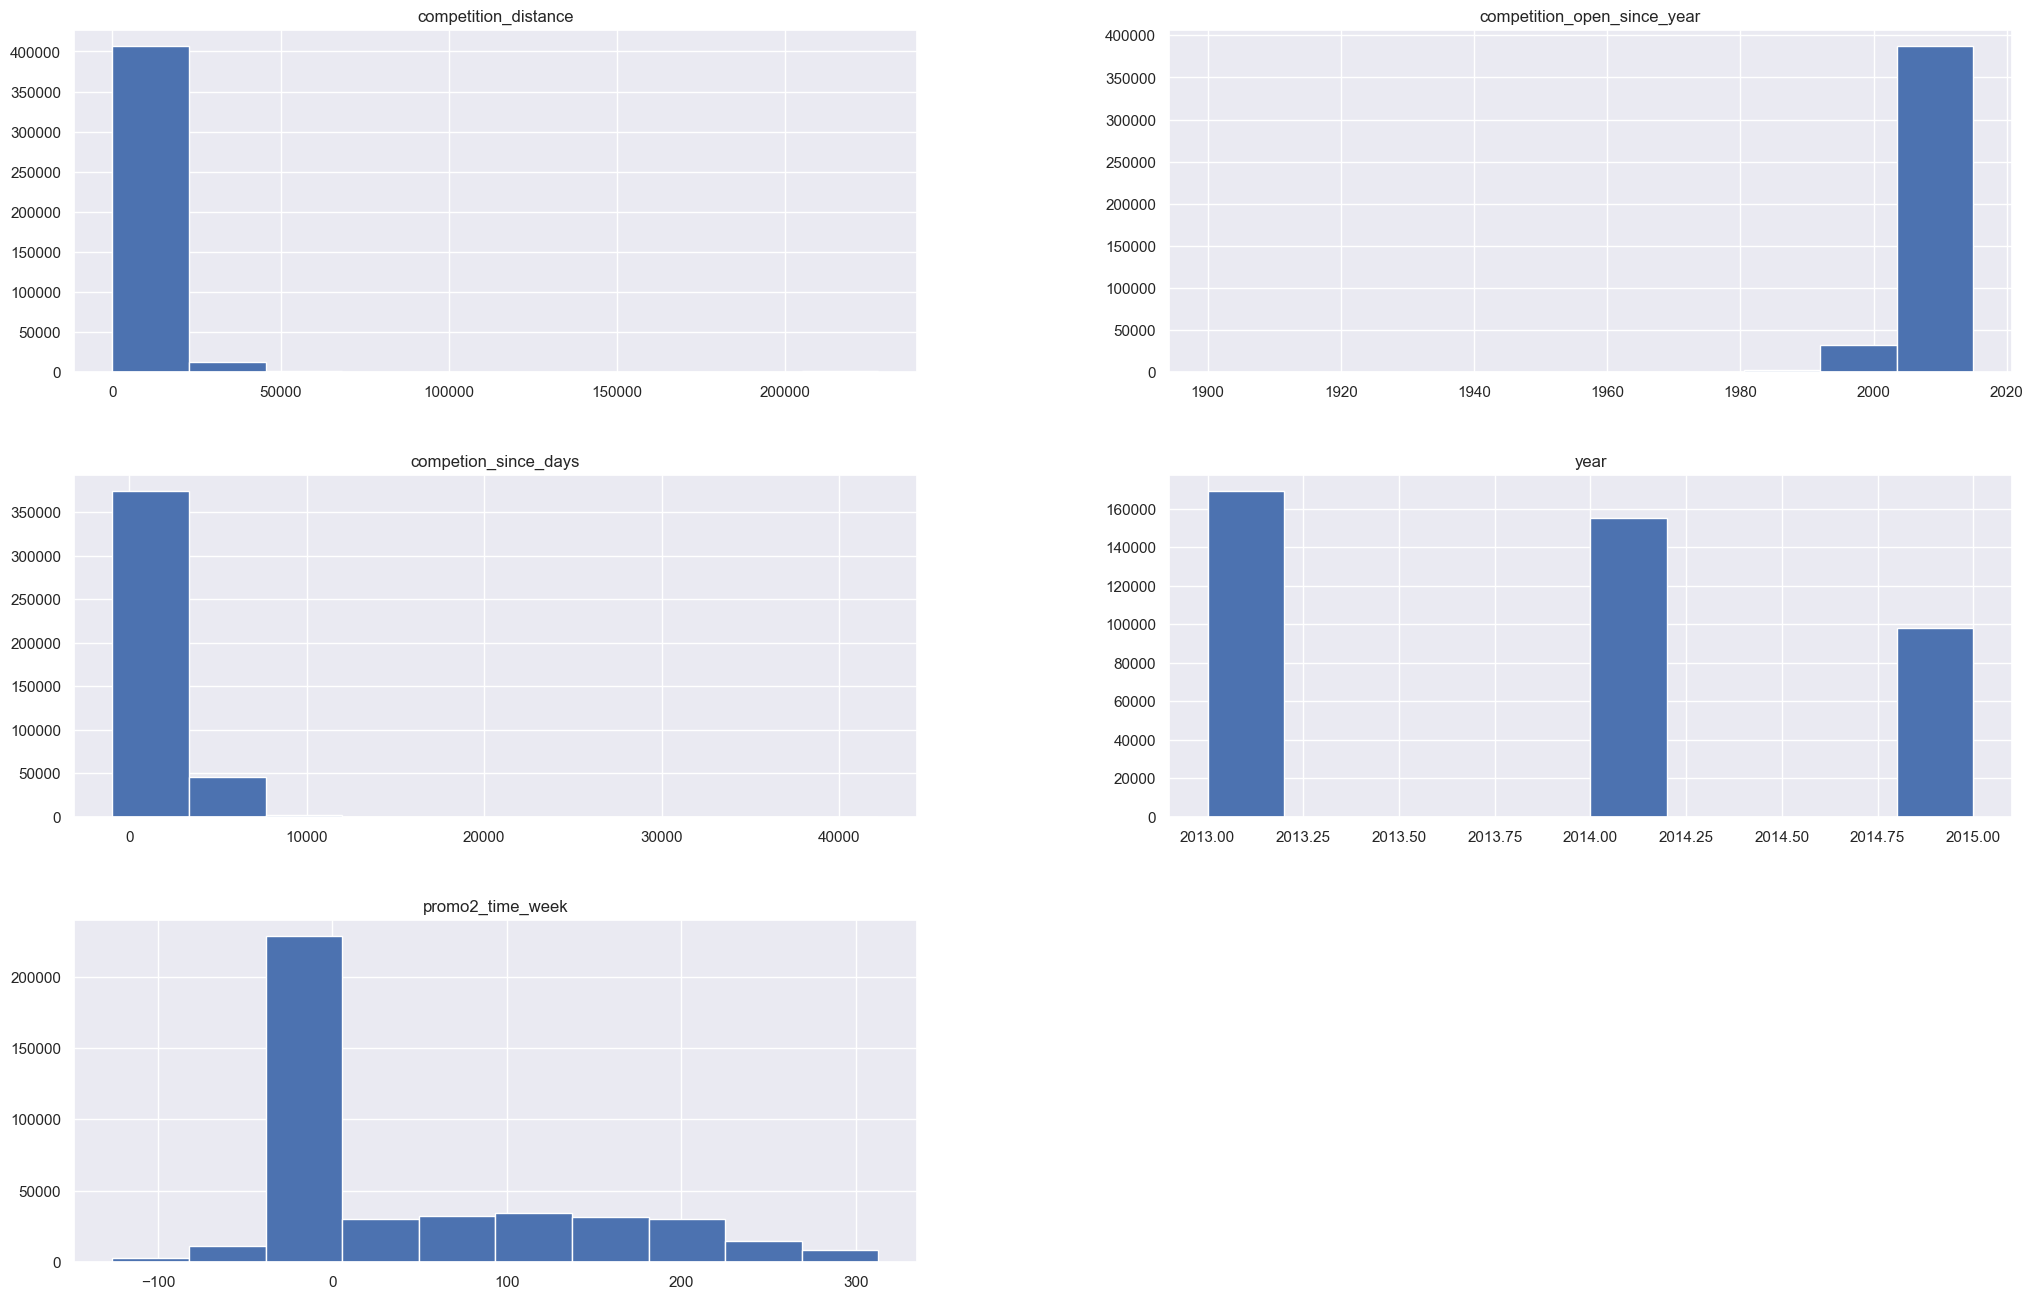

In [81]:
continuous_data = ['competition_distance',  'competition_open_since_year',  'competion_since_days',  'year','promo2_time_week']
df5[continuous_data].hist()  


In [82]:
robust_scallers = ['competition_distance', 'competion_since_days', 'competion_since_month', 'promo2_since_year']
outros_continuos = list(set(continuous_data) - set(robust_scallers))

Fora escolhido os robust_Scaller para as distribuições com forte presença de outliers, para as demais foi aplicado um minMax scaller  

Demais distribuições

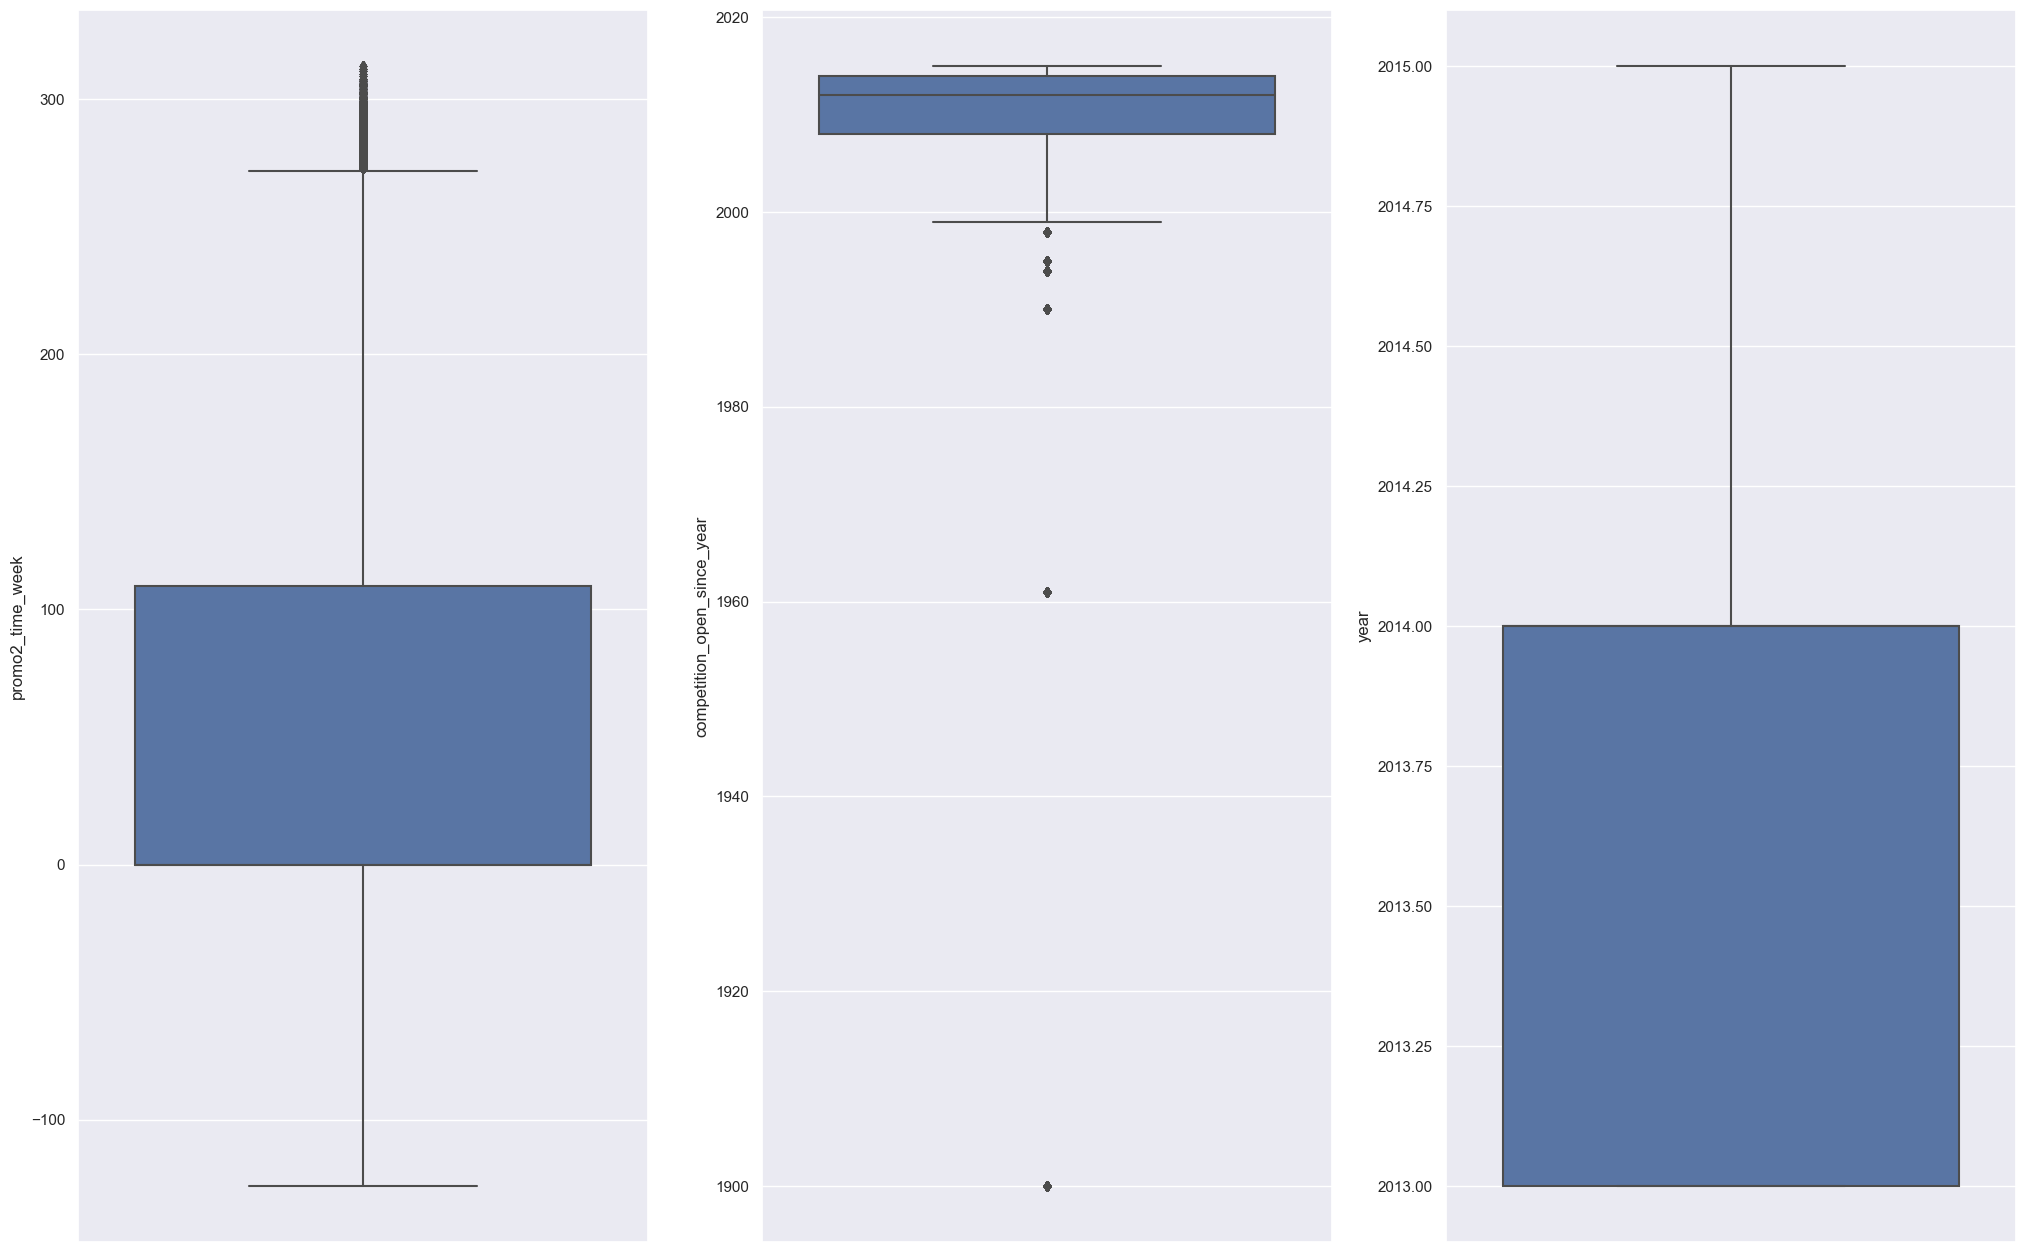

In [83]:
for idx, item in enumerate(outros_continuos):
    plt.subplot(1,len(outros_continuos),idx + 1)
    sns.boxplot(y = item, data = df5)


### 5.1.1 - Executando Transformações

In [84]:
X = df5[robust_scallers].values
robust_transformer = RobustScaler().fit(X)
dump_model(robust_transformer, './scallers/robustScaller.pkl')

df5[robust_scallers] =  robust_transformer.transform(X)


X = df5[outros_continuos].values
minMax_transformer = MinMaxScaler().fit(X)
dump_model(minMax_transformer, './scallers/minmaxSxaller.pkl')

\
df5[outros_continuos] =  minMax_transformer.transform(X)


**RESULTADO: MIN_MAX_SCALLER**

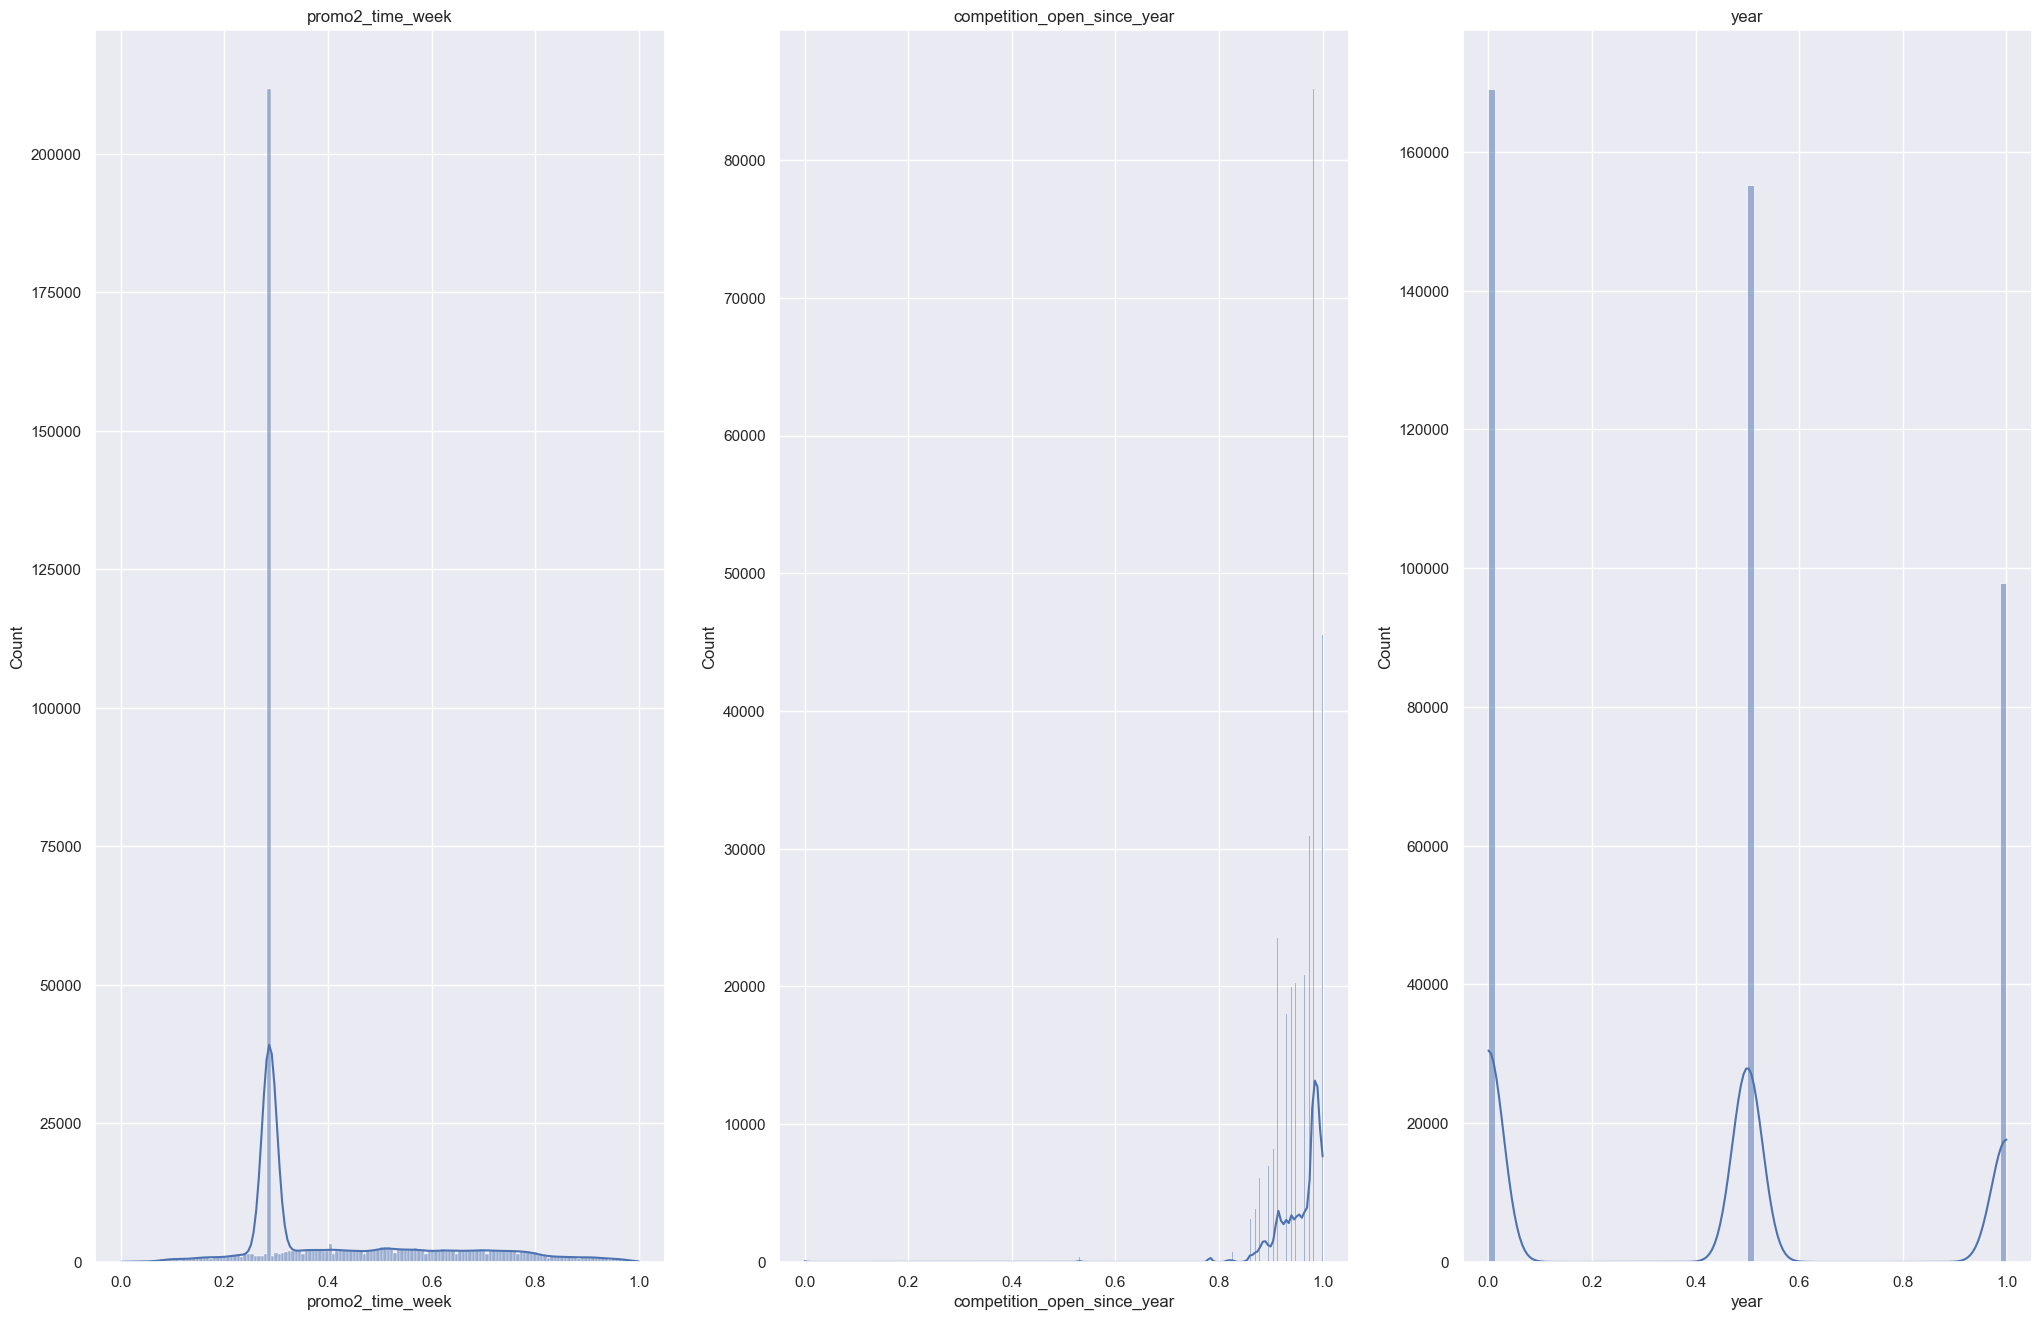

In [85]:
for idx, item in enumerate(outros_continuos):
    plt.subplot(1, len(outros_continuos), idx+1)
    plt.title(item)
    sns.histplot(df5[item], kde=True, fill = True)
    

**RESULTADO: ROBUST_SCALLER**

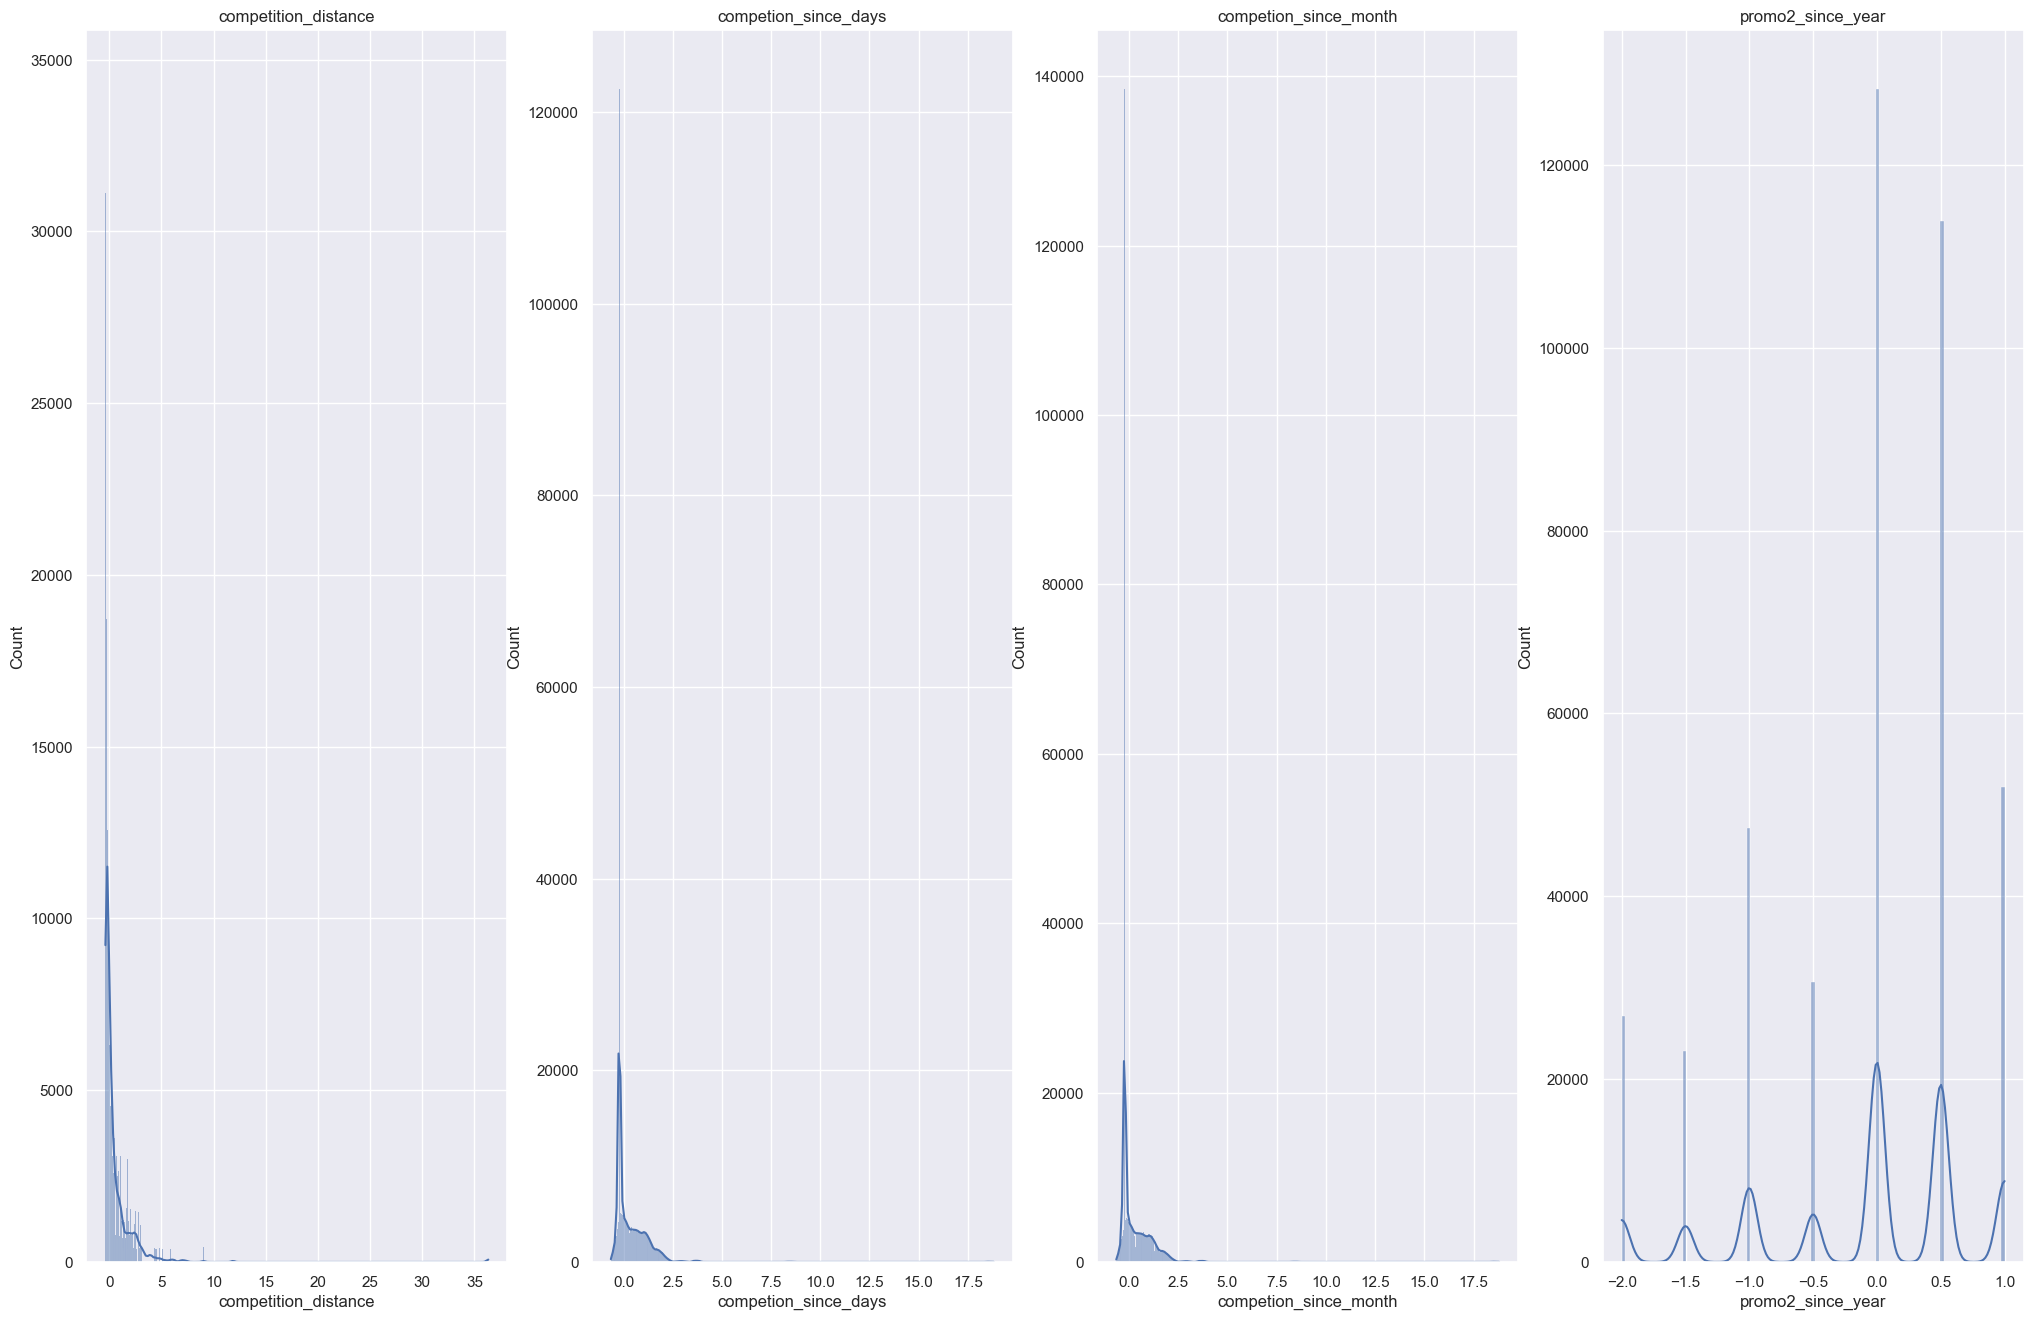

In [86]:
for idx, item in enumerate(robust_scallers):
    plt.subplot(1, len(robust_scallers), idx+1)
    plt.title(item)
    sns.histplot(df5[item], kde = True, fill = True)
    

## 5.2 - Transformações


### 5.2.1 - One Hot Enconding

In [87]:
text = df5.select_dtypes('object')
text.columns

Index(['state_holiday', 'store_type', 'assortment', 'promo_interval',
       'date_month', 'year_week'],
      dtype='object')

In [88]:
df5.school_holiday.value_counts()

school_holiday
0    340711
1     81596
Name: count, dtype: int64

In [89]:
df5.head()

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,...,is_promo,year,month,day,week_year,year_week,competion_since_days,competion_since_month,promo2_since,promo2_time_week
0,1,5,2015-07-31,5263,1,regular_day,1,c,basic,-0.170968,...,0,1.0,7,31,31,2015-30,0.910199,0.918919,2015-07-27,0.287016
3,4,5,2015-07-31,13995,1,regular_day,1,c,etended,-0.275806,...,0,1.0,7,31,31,2015-30,0.745487,0.743243,2015-07-27,0.287016
5,6,5,2015-07-31,5651,1,regular_day,1,a,basic,-0.325806,...,0,1.0,7,31,31,2015-30,0.045126,0.054054,2015-07-27,0.287016
8,9,5,2015-07-31,8565,1,regular_day,1,a,etended,-0.048387,...,0,1.0,7,31,31,2015-30,2.242780,2.243243,2015-07-27,0.287016
9,10,5,2015-07-31,7185,1,regular_day,1,a,basic,0.133871,...,0,1.0,7,31,31,2015-30,0.745487,0.743243,2015-07-27,0.287016


In [90]:
#   'state_holiday',                                               # 
df5 = pd.get_dummies(df5, prefix = ['state_holiday'], columns = ['state_holiday'], dtype=float)
   

### 5.2.2 - LabelEconding

In [91]:
#   'store_type',     
# Navalha de ockham - Escolher o a hipotese mais simples uma vez que tenho n hipoteses igualmente validas
label_enconder =LabelEncoder().fit(df5.store_type)
dump_model(label_enconder, './scallers/labelEncoder.pkl')

store_type = label_enconder.transform(df5.store_type)
df5.loc[:, 'store_type'] = store_type


### 5.2.3 OrdinalEnconding

In [92]:
# assortment 
# O sortimento possui uma caracteristica ordinal
# extended > extra > basic
dict_assortment = {
    'basic' : 0,
    'extra' : 1,
    'extended' : 2
}
df5.loc[:, 'assortment'] = df5.assortment.apply(lambda x: 'extended' if x == 'etended' else x)
df5.loc[:, 'assortment'] = df5.assortment.apply(lambda x: dict_assortment[x])


In [93]:
# Categoricos                                                      #     
#   'promo',                                                       # - ockham me diz para manter isso pois ela já é binaria - isso se encaixa com o dummy enconding original
#   'school_holiday',                                              # - mesmo do anterior
#   'promo2',                                                      # - mesmo do anterior 
#   'is_promo',                                                    # - mesmo do anterior 
#   'state_holiday',                                               # - mesmo do anterior 


In [94]:
#   'promo_interval',                                              #  -- remover


#Ciclico                                                           #
#   'day_of_week',                                                 #
#   'month',                                                       #
#   'date_month',  -remover                                                # 
#   'year_week'                                                    #
#   'day',                                                         #
#   'promo2_since_week',                                           #
#   'promo2_since_year',                                           #
#   'competition_open_since_month',                                #
#                                                                  #
####################################################################




In [95]:
df5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,...,week_year,year_week,competion_since_days,competion_since_month,promo2_since,promo2_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day
0,1,5,2015-07-31,5263,1,1,2,0,-0.170968,9,...,31,2015-30,0.910199,0.918919,2015-07-27,0.287016,0.0,0.0,0.0,1.0
3,4,5,2015-07-31,13995,1,1,2,2,-0.275806,9,...,31,2015-30,0.745487,0.743243,2015-07-27,0.287016,0.0,0.0,0.0,1.0
5,6,5,2015-07-31,5651,1,1,0,0,-0.325806,12,...,31,2015-30,0.045126,0.054054,2015-07-27,0.287016,0.0,0.0,0.0,1.0
8,9,5,2015-07-31,8565,1,1,0,2,-0.048387,8,...,31,2015-30,2.242780,2.243243,2015-07-27,0.287016,0.0,0.0,0.0,1.0
9,10,5,2015-07-31,7185,1,1,0,0,0.133871,9,...,31,2015-30,0.745487,0.743243,2015-07-27,0.287016,0.0,0.0,0.0,1.0


### 5.2.4 - Transformações de natureza

Transformações aplicadas aos dados para que numericamente possamos expressar sua natureza.
 
Neste caso, estamos interessandos em manter a natureza ciclica dos dados

Exemplo pratico: 1 (Janeiro) esta muito disante do 12 (dezembro) porém dezembro está muito proximo de janeiro e janeiro do outro ano muito proximo de dezembro

In [96]:
def ciclical_transformation(n_states : int, label):
    label_sen = f'{label}_seno'
    label_cos = f'{label}_cos'

    df5[label_sen] = df5[label].apply(lambda x: np.sin((2 * np.pi/n_states)))
    df5[label_cos] = df5[label].apply(lambda x: np.cos((2 * np.pi/n_states)))
    df5.rename(columns = {label : f'REPLACED_{label}'}, inplace=True)

    

In [97]:
#Ciclico                                                           #
#   'day_of_week',                                                 #
ciclical_transformation(7, 'day_of_week')

#   'month',                                                       #
ciclical_transformation(12, 'month')

#   'competition_open_since_month',                                #
ciclical_transformation(12, 'competition_open_since_month')

#   'week_year'                                                    #
ciclical_transformation(52, 'week_year')

#   'day',                                                         #
ciclical_transformation(30, 'day')

#   'promo2_since_week',                                           #
ciclical_transformation(52, 'promo2_since_week')



### 5.2.5 - Transformações da Target

In [98]:
df5.loc[:, 'sales'] = df0.loc[:, 'sales']

In [99]:
df5.sales.describe()
orignal_sales = df5.sales.copy().values 

Text(0.5, 1.0, 'Original_Values')

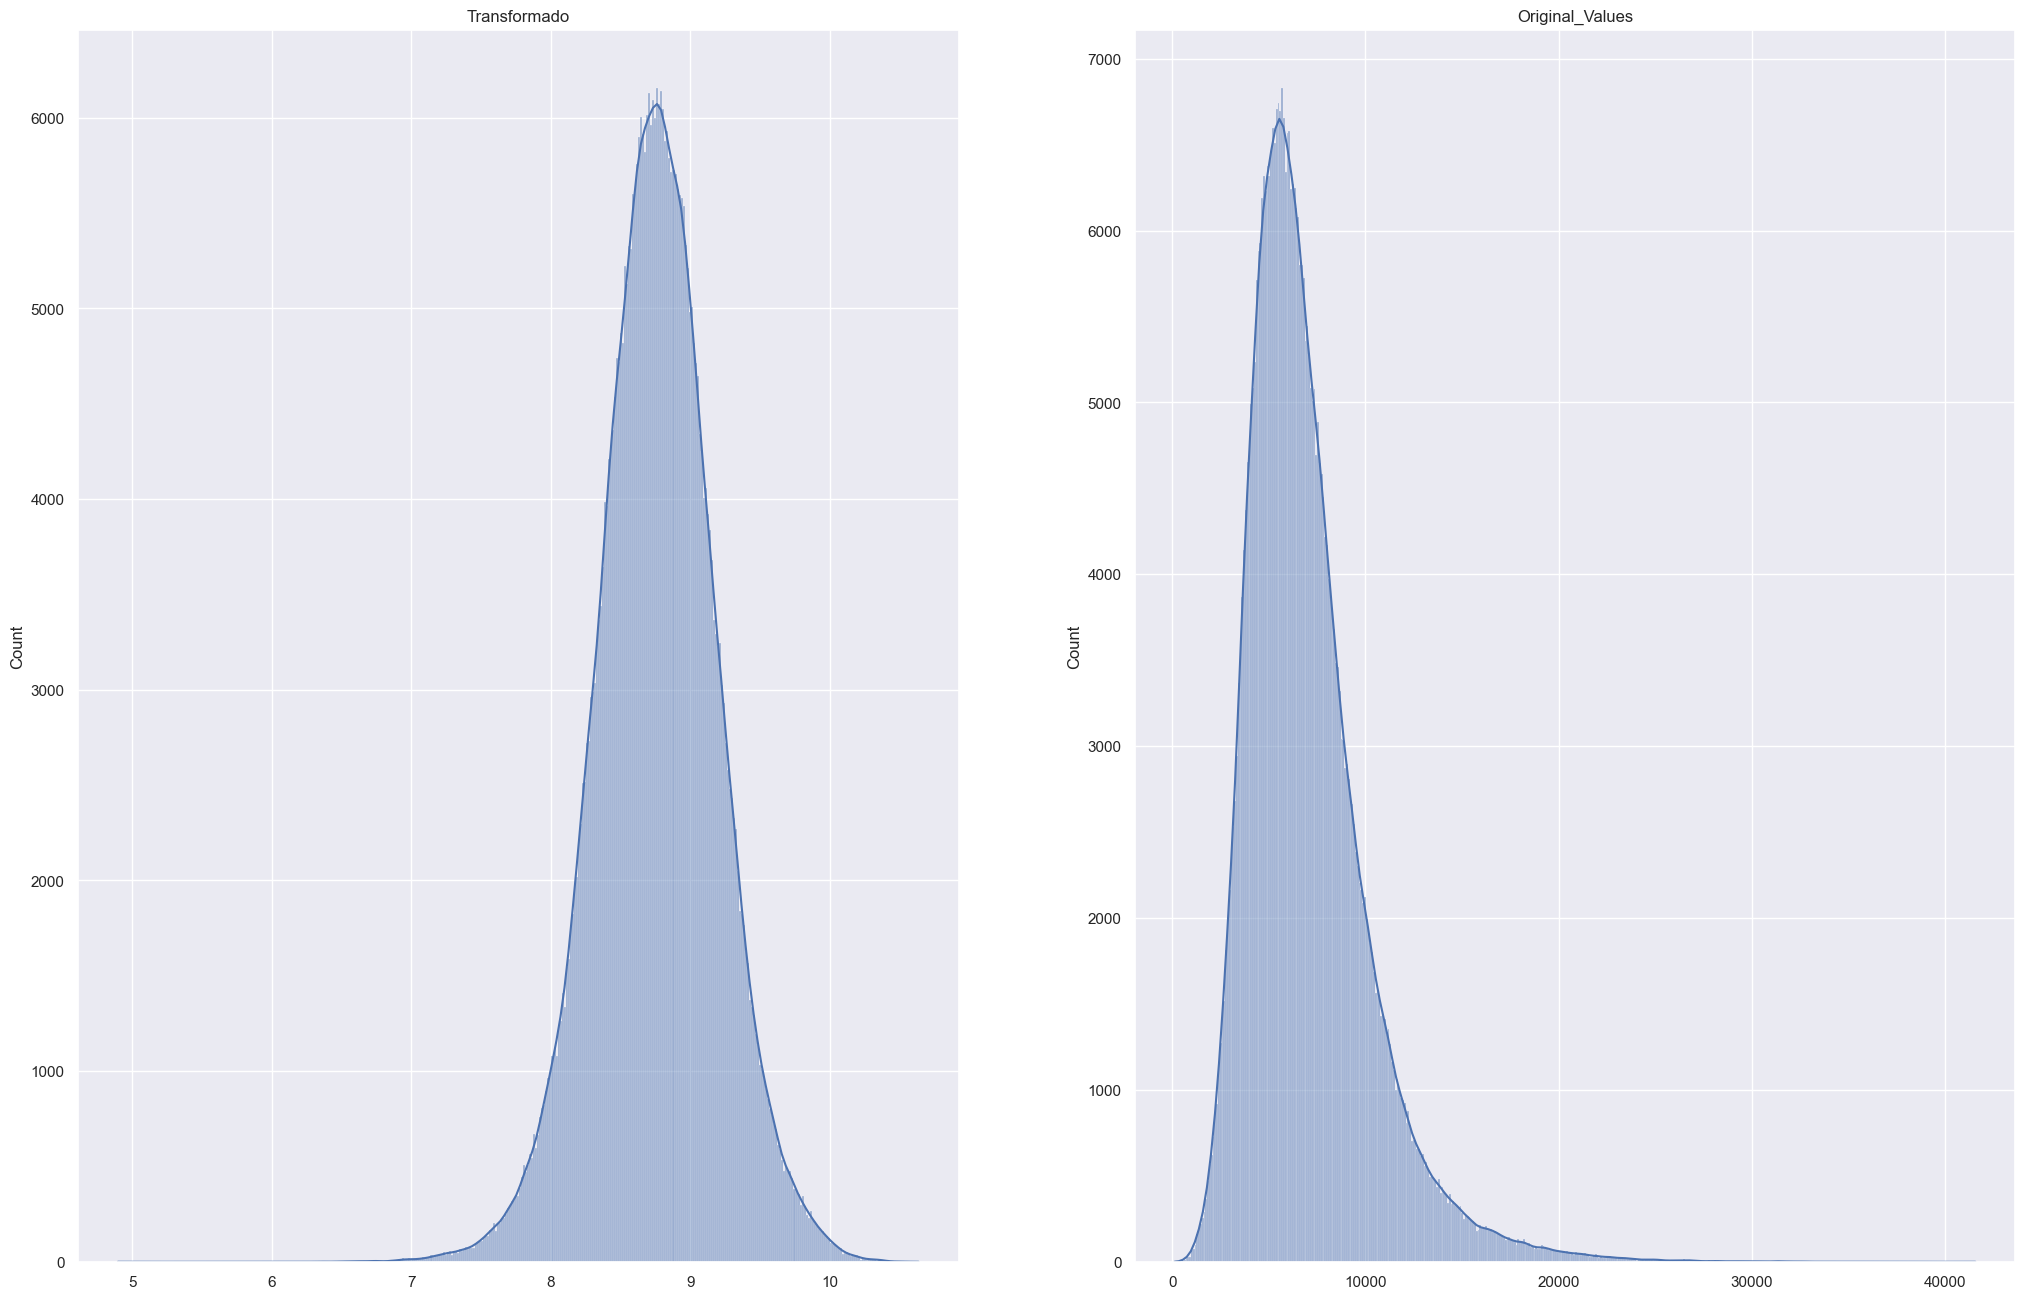

In [100]:
df5.loc[:, 'sales'] = np.log1p(df5.sales.values)
#df5.loc[:, 'sales'] = (df5.sales.values**(1/3))
plt.subplot(1,2,1)
sns.histplot(df5.sales.values, kde = True, fill = True)
plt.title('Transformado')

plt.subplot(1,2,2)
sns.histplot(orignal_sales, kde = True, fill = True)
plt.title('Original_Values')


# 6 - Seleção de Variáveis

In [27]:
df6 = df5.copy()

## 6.1 - Split DataFrame

In [28]:
drop_cols = [x for x in df6.columns.values if 'REPLACED' in x]
df6 = df6.drop(columns  = drop_cols)
df6.head()

,store,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_year,promo2,...,month_seno,month_cos,competition_open_since_month_seno,competition_open_since_month_cos,week_year_seno,week_year_cos,day_seno,day_cos,promo2_since_week_seno,promo2_since_week_cos
0,1,2015-07-31,8.568646,1,1,2,0,-0.170968,0.939130,0,...,0.5,0.866025,0.5,0.866025,0.120537,0.992709,0.207912,0.978148,0.120537,0.992709
3,4,2015-07-31,9.546527,1,1,2,2,-0.275806,0.947826,0,...,0.5,0.866025,0.5,0.866025,0.120537,0.992709,0.207912,0.978148,0.120537,0.992709
5,6,2015-07-31,8.639765,1,1,0,0,-0.325806,0.982609,0,...,0.5,0.866025,0.5,0.866025,0.120537,0.992709,0.207912,0.978148,0.120537,0.992709
8,9,2015-07-31,9.055556,1,1,0,2,-0.048387,0.869565,0,...,0.5,0.866025,0.5,0.866025,0.120537,0.992709,0.207912,0.978148,0.120537,0.992709
9,10,2015-07-31,8.879890,1,1,0,0,0.133871,0.947826,0,...,0.5,0.866025,0.5,0.866025,0.120537,0.992709,0.207912,0.978148,0.120537,0.992709


In [29]:

# Drop column: 'promo_interval'
df6 = df6.drop(columns=['promo_interval'])

# Drop column: 'date_month'
df6 = df6.drop(columns=['date_month'])

# Drop column: 'year_week'
df6 = df6.drop(columns=['year_week'])

# Drop column: 'promo2_since'
df6 = df6.drop(columns=['promo2_since'])

Ideia: Utilizar as ultimas 6 semanas de vendas para teste, pois por se tratar de uma série temporal, não é possível embaralhar os dados aleatoriamente

In [30]:
max_date = df6.date.max()
thresholding_date = max_date - datetime.timedelta(days = 7*6)
thresholding_date

Timestamp('2015-06-19 00:00:00')

In [31]:
for x in df6.columns:
    if x != 'date':
        if df6[x].dtype not in ('float32', 'float64', 'int32', 'int64'):
            print(x)
            df6.loc[:, x] = df6[x].apply(lambda x: float(x))
            df6[x] = df6[x].astype('float64')

store_type
assortment


In [32]:
train = df6[df6.date < thresholding_date]

x_cols = train.columns.values.tolist()
x_cols.remove('sales')
x_cols.remove('date')
x_cols.remove('competion_since_days')
x_cols.remove('promo2_since_week_seno')
x_cols.remove('promo2_since_week_cos')

x_train = train[x_cols].values
y_train = train['sales'].values


test = df6[df6.date >= thresholding_date]
x_test = test[x_cols].values
y_test = test['sales'].values

print(train.date.max())
print(test.date.max())

2015-06-18 00:00:00
2015-07-31 00:00:00


## 6.2 - Seleção de variaveis

### 6.2.1 - Boruta com Random Forest

In [33]:
'''model_rf = RandomForestRegressor(n_jobs= - 1)
boruta = BorutaPy(model_rf, n_estimators='auto', verbose=2, random_state=42, perc=70).fit(x_train, y_train)
'''

"model_rf = RandomForestRegressor(n_jobs= - 1)\nboruta = BorutaPy(model_rf, n_estimators='auto', verbose=2, random_state=42, perc=70).fit(x_train, y_train)\n"

In [34]:
'''

BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	11
Tentative: 	0
Rejected: 	16


'''

''' cols_selected = boruta.support_.tolist()
#
## best features
X_train_fs = train[x_cols]
cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()
#
## not selected boruta
cols_not_selected_boruta = list( np.setdiff1d( X_train_fs.columns, cols_selected_boruta ) )
'''



' cols_selected = boruta.support_.tolist()\n#\n## best features\nX_train_fs = train[x_cols]\ncols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()\n#\n## not selected boruta\ncols_not_selected_boruta = list( np.setdiff1d( X_train_fs.columns, cols_selected_boruta ) )\n'

In [35]:
cols_selected_boruta = [
    'store',
    'promo',
    'school_holiday',
    'store_type',
    'assortment',
    'competition_distance',
    'competition_open_since_year',
    'promo2',
    'promo2_since_year',
    'competion_since_month',
    'promo2_time_week'
 
 ]



In [36]:
cols_not_selected_boruta = [
    'competition_open_since_month_cos',
    'competition_open_since_month_seno',
    'day_cos',
    'day_of_week_cos',
    'day_of_week_seno',
    'day_seno',
    'is_promo',
    'month_cos',
    'month_seno',
    'state_holiday_christmas',
    'state_holiday_easter_holiday',
    'state_holiday_public_holiday',
    'state_holiday_regular_day',
    'week_year_cos',
    'week_year_seno',
    'year'
    ]

In [37]:
df6.columns

Index(['store', 'date', 'sales', 'promo', 'school_holiday', 'store_type',
       'assortment', 'competition_distance', 'competition_open_since_year',
       'promo2', 'promo2_since_year', 'is_promo', 'year',
       'competion_since_days', 'competion_since_month', 'promo2_time_week',
       'state_holiday_christmas', 'state_holiday_easter_holiday',
       'state_holiday_public_holiday', 'state_holiday_regular_day',
       'day_of_week_seno', 'day_of_week_cos', 'month_seno', 'month_cos',
       'competition_open_since_month_seno', 'competition_open_since_month_cos',
       'week_year_seno', 'week_year_cos', 'day_seno', 'day_cos',
       'promo2_since_week_seno', 'promo2_since_week_cos'],
      dtype='object')

In [38]:
cols_selected_by_me_and_boruta = cols_selected_boruta + ['day_of_week_cos', 'day_of_week_seno', 'promo']

#cols_selected_boruta = cols_selected_by_me_and_boruta

### 6.2.2 - Decision Tree feature_importances

In [39]:
regressor = DecisionTreeRegressor(random_state=42).fit(x_train, y_train)

score = regressor.feature_importances_
resultado = {x_cols[i] : score[i] for i in range(0, len(score)) }
resultado_df = pd.DataFrame(resultado, index = [x for x in range(0, len(score))])
resultado_df.loc[0].T.sort_values()


day_cos                              0.000000
week_year_cos                        0.000000
week_year_seno                       0.000000
competition_open_since_month_cos     0.000000
competition_open_since_month_seno    0.000000
month_cos                            0.000000
month_seno                           0.000000
day_of_week_cos                      0.000000
day_of_week_seno                     0.000000
day_seno                             0.000000
state_holiday_christmas              0.000026
state_holiday_easter_holiday         0.000042
state_holiday_public_holiday         0.000389
state_holiday_regular_day            0.001183
year                                 0.005042
is_promo                             0.005078
school_holiday                       0.012906
promo2                               0.016289
assortment                           0.026364
promo2_since_year                    0.030258
store_type                           0.044258
competition_open_since_year       

In [40]:
first_features_three = resultado_df.loc[0].T.sort_values(ascending=False).iloc[:11].index.values.tolist()

### 6.2.3 - Comparando resultados

In [41]:
set(first_features_three) - set(cols_selected_boruta)

set()

In [42]:
set(cols_selected_boruta) - set(first_features_three)

set()

**CONCLUSÃO:** O boruta selecionou todas as 11 features mais importantes, o mesmo resultado que uma decision tree simples obteve. 

O metodo neste caso se mostrou pouco vantajoso

**DECISÃO DE PROJETO:** Na primeira iteração do crisp, irei considerar somente as 11 features escolhidas pelo boruta. Posteriormente iremos inserir o conhecimento adquirido na EDA para aumentar/substituir as features.

# 7.0 - Os modelos de ML

## 7.0.1 - Preliminares

In [43]:
cols_selected_boruta

['store',
 'promo',
 'school_holiday',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_year',
 'promo2',
 'promo2_since_year',
 'competion_since_month',
 'promo2_time_week']

In [44]:
cols_selected = cols_selected_boruta + ['sales']
df7 = df6[cols_selected].copy()
df7.sample()

,store,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_year,promo2,promo2_since_year,competion_since_month,promo2_time_week,sales
588924,990,1,0,3.0,0.0,3.0,0.991304,0,0.5,-0.216216,0.287016,9.239316


In [45]:
x_train_selected = train[cols_selected_boruta]
x_test_selected = test[cols_selected_boruta]



## 7.0.1 - loss_functions

In [46]:
def RMSE(prediction : np.array, real : np.array) : 
    N = len(prediction)

    loss = (prediction - real)**2 
    loss = np.sum(loss)/N

    return np.sqrt(loss) 


def MAE(prediction : np.array, real : np.array):
    N = len(prediction)

    loss = np.mean(np.abs(prediction - real)) 

    return loss 


def MAPE(prediction : np.array, real : np.array):
    N = len(prediction)

    loss = np.mean(np.abs((prediction - real)/real)) 


    return loss 


def loss(prediction : np.array, real : np.array, model_name):
    rmse = RMSE(prediction, real)
    mape = MAPE(prediction, real)
    mae =  MAE(prediction, real)
    
    
    
    return pd.DataFrame({
        'Model_name' : model_name, 
        'RMSE' : rmse ,
        'MAPE' : mape ,
        'MAE' : mae
    }, index = [0])



## 7.1 - Modelos Lineares


| Modelo |   MAE  | MAPE   |  RMSE  |
|--------|--------|--------|--------|
| Média  | 1430   | 0.22   | 1943.1 |
| LR     | 1903.8 | 0.29   | 2720.4 |
|LR-Lasso| 1904.4 | 0.30   | 2743.63|


**Vemos que os modelos de regressão se sairam piores que a média a vista do RMSE, MAPE e MAE**

O que evidencia um comportamento não linear dos dados, lenvando a exploração de modelos não lineares

### 7.1 - Average Model

In [47]:
mean_model = x_train_selected.copy() 
def mean_model(data):
        
    mean_model['sales'] = y_train 

    mean_model_prediction = mean_model.groupby('store').agg({'sales' : 'mean'}).reset_index()
    mean_model_prediction.rename(columns = {'sales' : 'predict'}, inplace=True)

    store = mean_model_prediction.store.values 
    predictions = mean_model_prediction.predict.values

    dict_model = {store[idx] : predictions[idx] for idx in range(0,len(store)) }


    mean_model['predict'] = mean_model.store.apply(lambda x: dict_model[x])

    y_hat_test = test['store'].apply(lambda x: dict_model[x])
    #root_mean_loss(mean_model['predict'], mean_model['sales'])

mean_model

,store,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_year,promo2,promo2_since_year,competion_since_month,promo2_time_week,sales,predict
47945,1,1,0,2.0,0.0,-0.170968,0.939130,0,1.0,0.891892,0.287016,8.443762,8.445134
47947,3,1,0,0.0,0.0,1.903226,0.921739,1,-1.0,1.189189,0.788155,8.927712,8.798036
47950,6,1,0,0.0,0.0,-0.325806,0.982609,0,1.0,0.027027,0.287016,8.390723,8.580194
47951,7,1,0,0.0,2.0,3.495161,0.982609,0,1.0,0.135135,0.287016,9.100079,9.051535
47954,10,1,0,0.0,0.0,0.133871,0.947826,0,1.0,0.729730,0.287016,8.670772,8.600487
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1016776,682,0,1,1.0,0.0,-0.351613,0.921739,0,0.0,0.824324,0.287016,8.124447,9.273551
1016827,733,0,1,1.0,1.0,-0.237097,0.860870,0,0.0,1.959459,0.287016,9.284148,9.609408
1016863,769,0,1,1.0,1.0,-0.240323,0.982609,1,-0.5,-0.216216,0.300683,8.524367,9.259400
1017042,948,0,1,1.0,1.0,-0.145161,0.982609,0,0.0,-0.216216,0.287016,8.410053,8.805507


In [48]:
result_avarage = loss(np.expm1(y_hat_test), np.expm1(y_test) ,'average_model')

In [49]:
test['sales'] = y_test
aux1 = test.groupby('store').agg({'sales' : 'mean'}).reset_index().rename(columns = {'sales':'predict'})
aux2 = test.merge(aux1, on = 'store', how = 'left')
loss(np.expm1(aux2.predict.values), np.expm1(aux2.sales.values) ,'average_model')

C:\Users\ricar\AppData\Local\Temp\ipykernel_10868\3198437322.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['sales'] = y_test


,Model_name,RMSE,MAPE,MAE
0,average_model,1821.450063,0.204487,1336.274598


### 7.2 - Linear Regression Model

In [50]:
lr_model = LinearRegression().fit(x_train_selected, y_train)

predict_lr = lr_model.predict(x_test_selected)

result_lr = loss(np.expm1(predict_lr), np.expm1(y_test ), 'linear_regression')


### 7.3 - Linear Regression Regularized Model - Lasso

In [51]:
lrr_model = Lasso(alpha = 0.0001).fit(x_train_selected, y_train)

predict_lrr = lrr_model.predict(x_test_selected)

result_lr_lasso = loss(np.expm1(predict_lrr), np.expm1(y_test), 'linear_regression - Lasso')


## 7.2 - Modelos Não lineares

* XGBosst
* Random Forest

### 7.2.1 - Random Forest

In [52]:
rf_model = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42).fit(x_train_selected, y_train)

prediction_rf = rf_model.predict(x_test_selected)


result_rf = loss(np.expm1(prediction_rf), np.expm1(y_test ), 'RF')

result_rf



,Model_name,RMSE,MAPE,MAE
0,RF,1507.987595,0.166568,1076.791374


In [53]:
result_rf1 = result_rf

result_rf1

,Model_name,RMSE,MAPE,MAE
0,RF,1507.987595,0.166568,1076.791374


In [54]:
x_test_selected

,store,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_year,promo2,promo2_since_year,competion_since_month,promo2_time_week
0,1,1,1,2.0,0.0,-0.170968,0.939130,0,1.0,0.918919,0.287016
3,4,1,1,2.0,2.0,-0.275806,0.947826,0,1.0,0.743243,0.287016
5,6,1,1,0.0,0.0,-0.325806,0.982609,0,1.0,0.054054,0.287016
8,9,1,1,0.0,2.0,-0.048387,0.869565,0,1.0,2.243243,0.287016
9,10,1,1,0.0,0.0,0.133871,0.947826,0,1.0,0.743243,0.287016
...,...,...,...,...,...,...,...,...,...,...,...
47935,1106,1,0,0.0,2.0,0.483871,0.965217,1,0.0,0.405405,0.510251
47937,1108,1,0,0.0,0.0,-0.288710,0.904348,0,1.0,1.621622,0.287016
47938,1109,1,0,2.0,0.0,0.187097,0.965217,1,-0.5,0.472973,0.651481
47939,1110,1,0,2.0,2.0,-0.230645,0.956522,0,1.0,0.567568,0.287016


### 7.2.2 XGBoost

In [55]:
model_xgb = xgb.XGBRegressor(
                            objective='reg:squarederror',
                            n_estimators=1000,
                            eta=0.01,
                            max_depth = 10, 
                            subsample = 0.7,
                            colsample_bytree = 0.9).fit(x_train_selected.values, y_train)

prediction_xgb = model_xgb.predict(x_test_selected.values)


result_xgb = loss(np.expm1(prediction_xgb), np.expm1(y_test), 'XGB')

result_xgb



,Model_name,RMSE,MAPE,MAE
0,XGB,1430.871749,0.159073,1016.872907


In [56]:
results = [result_xgb, result_rf1, result_lr_lasso, result_lr, result_avarage]
results = pd.concat(results).sort_values(by = ['RMSE', 'MAPE'], ascending = True)
results

,Model_name,RMSE,MAPE,MAE
0,XGB,1430.871749,0.159073,1016.872907
0,RF,1507.987595,0.166568,1076.791374
0,average_model,1943.185700,0.218060,1429.720075
0,linear_regression,2720.420750,0.302685,1903.861364
0,linear_regression - Lasso,2743.633512,0.297743,1904.421465


## 7.3 - Cross Validations

In [57]:
dict_models = {
    'LR' : LinearRegression(),
    
    'LRR - Regularized' : Lasso(alpha = 0.001),

    'RandomForest' : RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42),
    
    'XGB' : xgb.XGBRegressor(
                            objective='reg:squarederror',
                            n_estimators=1000,
                            eta=0.01,
                            max_depth = 10, 
                            subsample = 0.7,
                            colsample_bytree = 0.9)
    
}

'''dict_models = {
    
    
    'XGB' : xgb.XGBRegressor(
                            objective='reg:squarederror',
                            n_estimators=1000,
                            eta=0.01,
                            max_depth = 10, 
                            subsample = 0.7,
                            colsample_bytree = 0.9)
    
}'''


corss_validation = ts_cross_validation.time_series_k_fold_validation(
                                                    k_fold = 5,
                                                    dict_models = dict_models,
                                                    train_data = train,
                                                    week_split_time = 6,
                                                    features_train=cols_selected_boruta,
                                                    target='sales',
                                                    loss_function = loss
                                                ) 

result_cross_validation = corss_validation.cross_validation_time_series()


Kfold --> 0
Kfold --> 1
Kfold --> 2
Kfold --> 3


KeyboardInterrupt: 

Resultados iniciais

In [ ]:
results

,Model_name,RMSE,MAPE,MAE
0,XGB,1430.871749,0.159073,1016.872907
0,RF,1507.987595,0.166568,1076.791374
0,average_model,1943.185700,0.218060,1429.720075
0,linear_regression,2720.420750,0.302685,1903.861364
0,linear_regression - Lasso,2743.633512,0.297743,1904.421465


**Resultados Cross validation**

In [ ]:
result_cross_validation.sort_values(by = 'RMSE', ascending=True)

,Model_name,RMSE,MAPE,MAE,STD_RMSE,STD_MAPE,STD_MAE
0,XGB,1818.92021,0.175577,1305.550643,627.272618,0.033818,440.962404


# 8.0 - Fine Tuning

## 8.1 - Random Search

In [ ]:
import random 
if runRandomSearch:
    hp = {
        'n_estimators'      : [1000, 2500, 3500],
        'eta'               : [0.01, 0.03],
        'max_depth'         : [10, 5, 15],
        'subsample'         : [0.7, 0.2, 0.5],
        'colsample_bytree'  : [0.9, 0.3, 0.7],
        'min_child_weight'  : [3, 8 ,15]
    }


    def randomSearch(train_data : pd.DataFrame,
                    hiperparameters : dict,
                    MAX_EVAL : int = 10):
        
        results_hp = []

        for iteration in range(0, MAX_EVAL):
            evaluated_hp = {key : random.sample(value, 1) for key, value in hiperparameters.items()}

            print(evaluated_hp)
            current_model = {
                        'xgb_regressor' : xgb.XGBRegressor(
                                objective='reg:squarederror',
                                n_estimators        =   evaluated_hp['n_estimators'][0],
                                eta                 =   evaluated_hp['eta'][0],
                                max_depth           =   evaluated_hp['max_depth'][0],
                                subsample           =   evaluated_hp['subsample'][0],
                                colsample_bytree    =   evaluated_hp['colsample_bytree'][0]
                            )
                }


            cross_validation = ts_cross_validation.time_series_k_fold_validation(
                                                                k_fold = 5,
                                                                dict_models = current_model,
                                                                train_data = train_data,
                                                                week_split_time = 6,
                                                                features_train=cols_selected_boruta,
                                                                target='sales',
                                                                loss_function = loss
                                                                ) 

            result_cross_validation = cross_validation.cross_validation_time_series()

            evaluated_hp_df = pd.DataFrame(evaluated_hp, index = [0])
            
            result_cross_validation  = pd.concat([result_cross_validation, evaluated_hp_df], axis = 1)

            print(evaluated_hp)

            results_hp.append(result_cross_validation)

        results = pd.concat(results_hp)

        return results 

    random_search_result = randomSearch(train, hp, 15)
    random_search_result.to_csv('./randomSearchResult.csv', sep = ';')
    random_search_result.sort_values(by = 'RMSE')
else:
    random_search_result = pd.read_csv('./randomSearchResult.csv', sep = ';')

## 8.2 - Training Best Model

In [ ]:
best_model = xgb.XGBRegressor(
                            objective='reg:squarederror',
                            n_estimators        =   random_search_result.loc[0,'n_estimators'],
                            eta                 =   random_search_result.loc[0,'eta'],
                            max_depth           =   random_search_result.loc[0,'max_depth'],
                            subsample           =   random_search_result.loc[0,'subsample'],
                            colsample_bytree    =   random_search_result.loc[0,'colsample_bytree']
                        ).fit(x_train_selected, y_train)




## 8.3 - Saving Best Model

In [62]:
pickle.dump(best_model, 
            open('./models/xgb_tunned.pkl', 'wb'))
prediction_best_xgb = best_model.predict(x_test_selected)
best_model_loss = loss(np.expm1(prediction_best_xgb.values), np.expm1(y_test), 'BEST_XGB')
best_model_loss

NameError: name 'best_model' is not defined

# 9.0 - Interpretação do erro

In [72]:
import joblib
model  = joblib.load('./models/xgb_tunned.pkl' ,'rb')

prediction_best_xgb = model.predict(x_test_selected.values)
best_model_loss = loss(np.expm1(prediction_best_xgb), np.expm1(y_test), 'BEST_XGB')
best_model_loss

,Model_name,RMSE,MAPE,MAE
0,BEST_XGB,1441.506049,0.160392,1026.21103


In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20616 entries, 0 to 47944
Data columns (total 32 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   store                              20616 non-null  int64         
 1   date                               20616 non-null  datetime64[ns]
 2   sales                              20616 non-null  float64       
 3   promo                              20616 non-null  int64         
 4   school_holiday                     20616 non-null  int64         
 5   store_type                         20616 non-null  float64       
 6   assortment                         20616 non-null  float64       
 7   competition_distance               20616 non-null  float64       
 8   competition_open_since_year        20616 non-null  float64       
 9   promo2                             20616 non-null  int64         
 10  promo2_since_year                  2061

In [ ]:
df9 = x_test_selected.copy()
df9['date'] = test['date']

df9['sales'] = y_test
df9['predictions'] = prediction_best_xgb

# reescaling 
df9['sales']       =    np.expm1(df9['sales']) 
df9['predictions'] =    np.expm1(df9['predictions'])

df9.head()

,store,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_year,promo2,promo2_since_year,competion_since_month,promo2_time_week,date,sales,predictions
0,1,1,1,2.0,0.0,-0.170968,0.939130,0,1.0,0.918919,0.287016,2015-07-31,5263.0,5641.580566
3,4,1,1,2.0,2.0,-0.275806,0.947826,0,1.0,0.743243,0.287016,2015-07-31,13995.0,10384.234375
5,6,1,1,0.0,0.0,-0.325806,0.982609,0,1.0,0.054054,0.287016,2015-07-31,5651.0,6745.512695
8,9,1,1,0.0,2.0,-0.048387,0.869565,0,1.0,2.243243,0.287016,2015-07-31,8565.0,8852.141602
9,10,1,1,0.0,0.0,0.133871,0.947826,0,1.0,0.743243,0.287016,2015-07-31,7185.0,6717.429199


### 9.0.1 - Melhor e pior Cenario por Loja

In [ ]:
df9_MAE = df9[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: MAE(x['predictions'], x['sales'])).reset_index().rename(columns = {0 : 'MAE'})
df9_MAPE = df9[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: MAPE(x['predictions'], x['sales'])).reset_index().rename(columns = {0 : 'MAPE'})

df9_loss = df9_MAE.merge(df9_MAPE, how = 'inner', on = 'store')

# Quanto dinheiro ira entrar no periodo
df9_store_count = df9[['store', 'sales']].groupby('store').count().reset_index().rename(columns = {'sales' : 'occurrencies'})
df9_sum  = df9[['store', 'predictions']].groupby('store').sum().reset_index()

df9_loss = df9_loss.merge(df9_sum, how = 'inner', on = 'store')
df9_loss = df9_loss.merge(df9_store_count, how = 'inner', on = 'store')

# Obtendo o erro TOTAL 
df9_loss['TOTAL_MAE'] = df9_loss['MAE'] * df9_loss['occurrencies'] 

df9_loss = df9_loss[['store', 'predictions', 'MAE', 'TOTAL_MAE', 'MAPE']]

df9_loss['WORST_SCENARIO']  = df9_loss['predictions'] - df9_loss['TOTAL_MAE'] 
df9_loss['BEST_SCENARIO']   = df9_loss['predictions'] + df9_loss['TOTAL_MAE']


df9_loss


,store,predictions,MAE,TOTAL_MAE,MAPE,WORST_SCENARIO,BEST_SCENARIO
0,1,82996.476562,405.241007,7294.338135,0.091467,75702.138428,90290.814697
1,2,87773.968750,793.987762,12703.804199,0.153383,75070.164551,100477.772949
2,3,132354.265625,1339.948914,21439.182617,0.185364,110915.083008,153793.448242
3,4,142938.625000,1167.376129,18678.018066,0.111998,124260.606934,161616.643066
4,5,124298.484375,801.013711,20025.342773,0.173443,104273.141602,144323.827148
...,...,...,...,...,...,...,...
1110,1111,89023.367188,1370.065887,21921.054199,0.358631,67102.312988,110944.421387
1111,1112,195137.375000,2060.624897,39151.873047,0.260140,155985.501953,234289.248047
1112,1113,93684.164062,925.518930,12031.746094,0.160212,81652.417969,105715.910156
1113,1114,245207.500000,2530.598796,30367.185547,0.108150,214840.314453,275574.685547


<Axes: xlabel='store', ylabel='MAPE'>

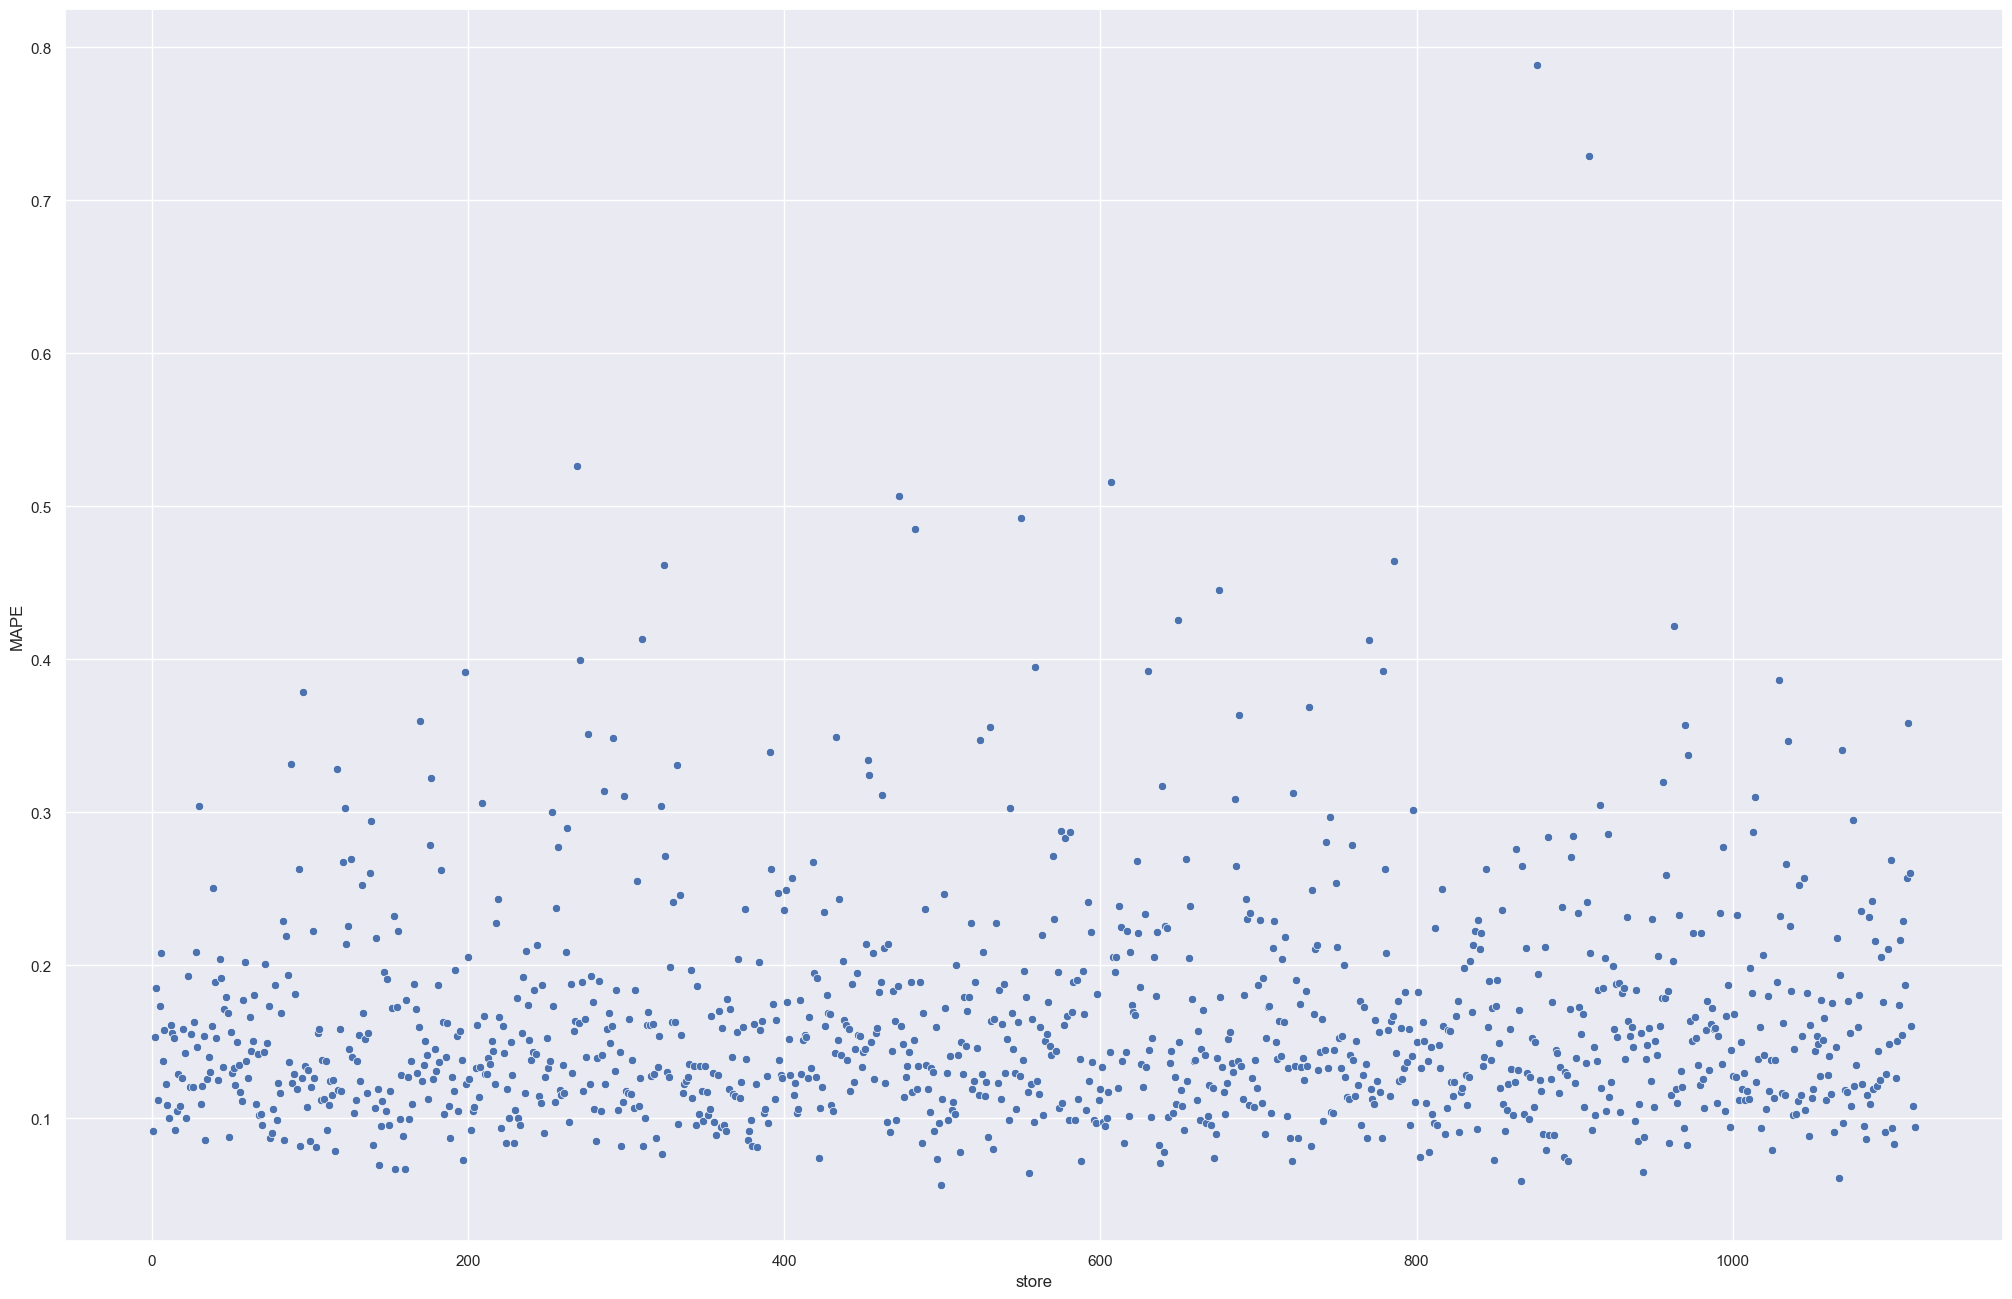

In [ ]:
sns.scatterplot(df9_loss, x = 'store', y = 'MAPE')


## 9.2 - Total Performance

In [ ]:
df9_resumo = df9_loss[['predictions','BEST_SCENARIO', 'WORST_SCENARIO']].sum()

print('''
    Predictions : R$ {:,.2f}  
    Melhor cenário: R$ {:,.2f}
    Pior cenário: R$ {:,.2f}
 '''.format(
     round(df9_resumo['predictions']),
     round(df9_resumo['BEST_SCENARIO']), 
     round(df9_resumo['WORST_SCENARIO'])))
 



    Predictions : R$ 145,244,160.00  
    Melhor cenário: R$ 166,400,531.00
    Pior cenário: R$ 124,087,798.00
 


A variação dos cenarios esta bastante consideravel, avaliar melhorias no proximo ciclo


In [ ]:
df9

,store,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_year,promo2,promo2_since_year,competion_since_month,promo2_time_week,sales,predictions
0,1,1,1,2.0,0.0,-0.170968,0.939130,0,1.0,0.918919,0.287016,5263.0,5641.580566
3,4,1,1,2.0,2.0,-0.275806,0.947826,0,1.0,0.743243,0.287016,13995.0,10384.234375
5,6,1,1,0.0,0.0,-0.325806,0.982609,0,1.0,0.054054,0.287016,5651.0,6745.512695
8,9,1,1,0.0,2.0,-0.048387,0.869565,0,1.0,2.243243,0.287016,8565.0,8852.141602
9,10,1,1,0.0,0.0,0.133871,0.947826,0,1.0,0.743243,0.287016,7185.0,6717.429199
...,...,...,...,...,...,...,...,...,...,...,...,...,...
47935,1106,1,0,0.0,2.0,0.483871,0.965217,1,0.0,0.405405,0.510251,5541.0,6516.279297
47937,1108,1,0,0.0,0.0,-0.288710,0.904348,0,1.0,1.621622,0.287016,6587.0,7151.467285
47938,1109,1,0,2.0,0.0,0.187097,0.965217,1,-0.5,0.472973,0.651481,5119.0,6167.582520
47939,1110,1,0,2.0,2.0,-0.230645,0.956522,0,1.0,0.567568,0.287016,5399.0,6061.878418


## 9.3 - Machine Learning Performance

In [ ]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions']/df9['sales']


<Axes: xlabel='predictions', ylabel='error_rate'>

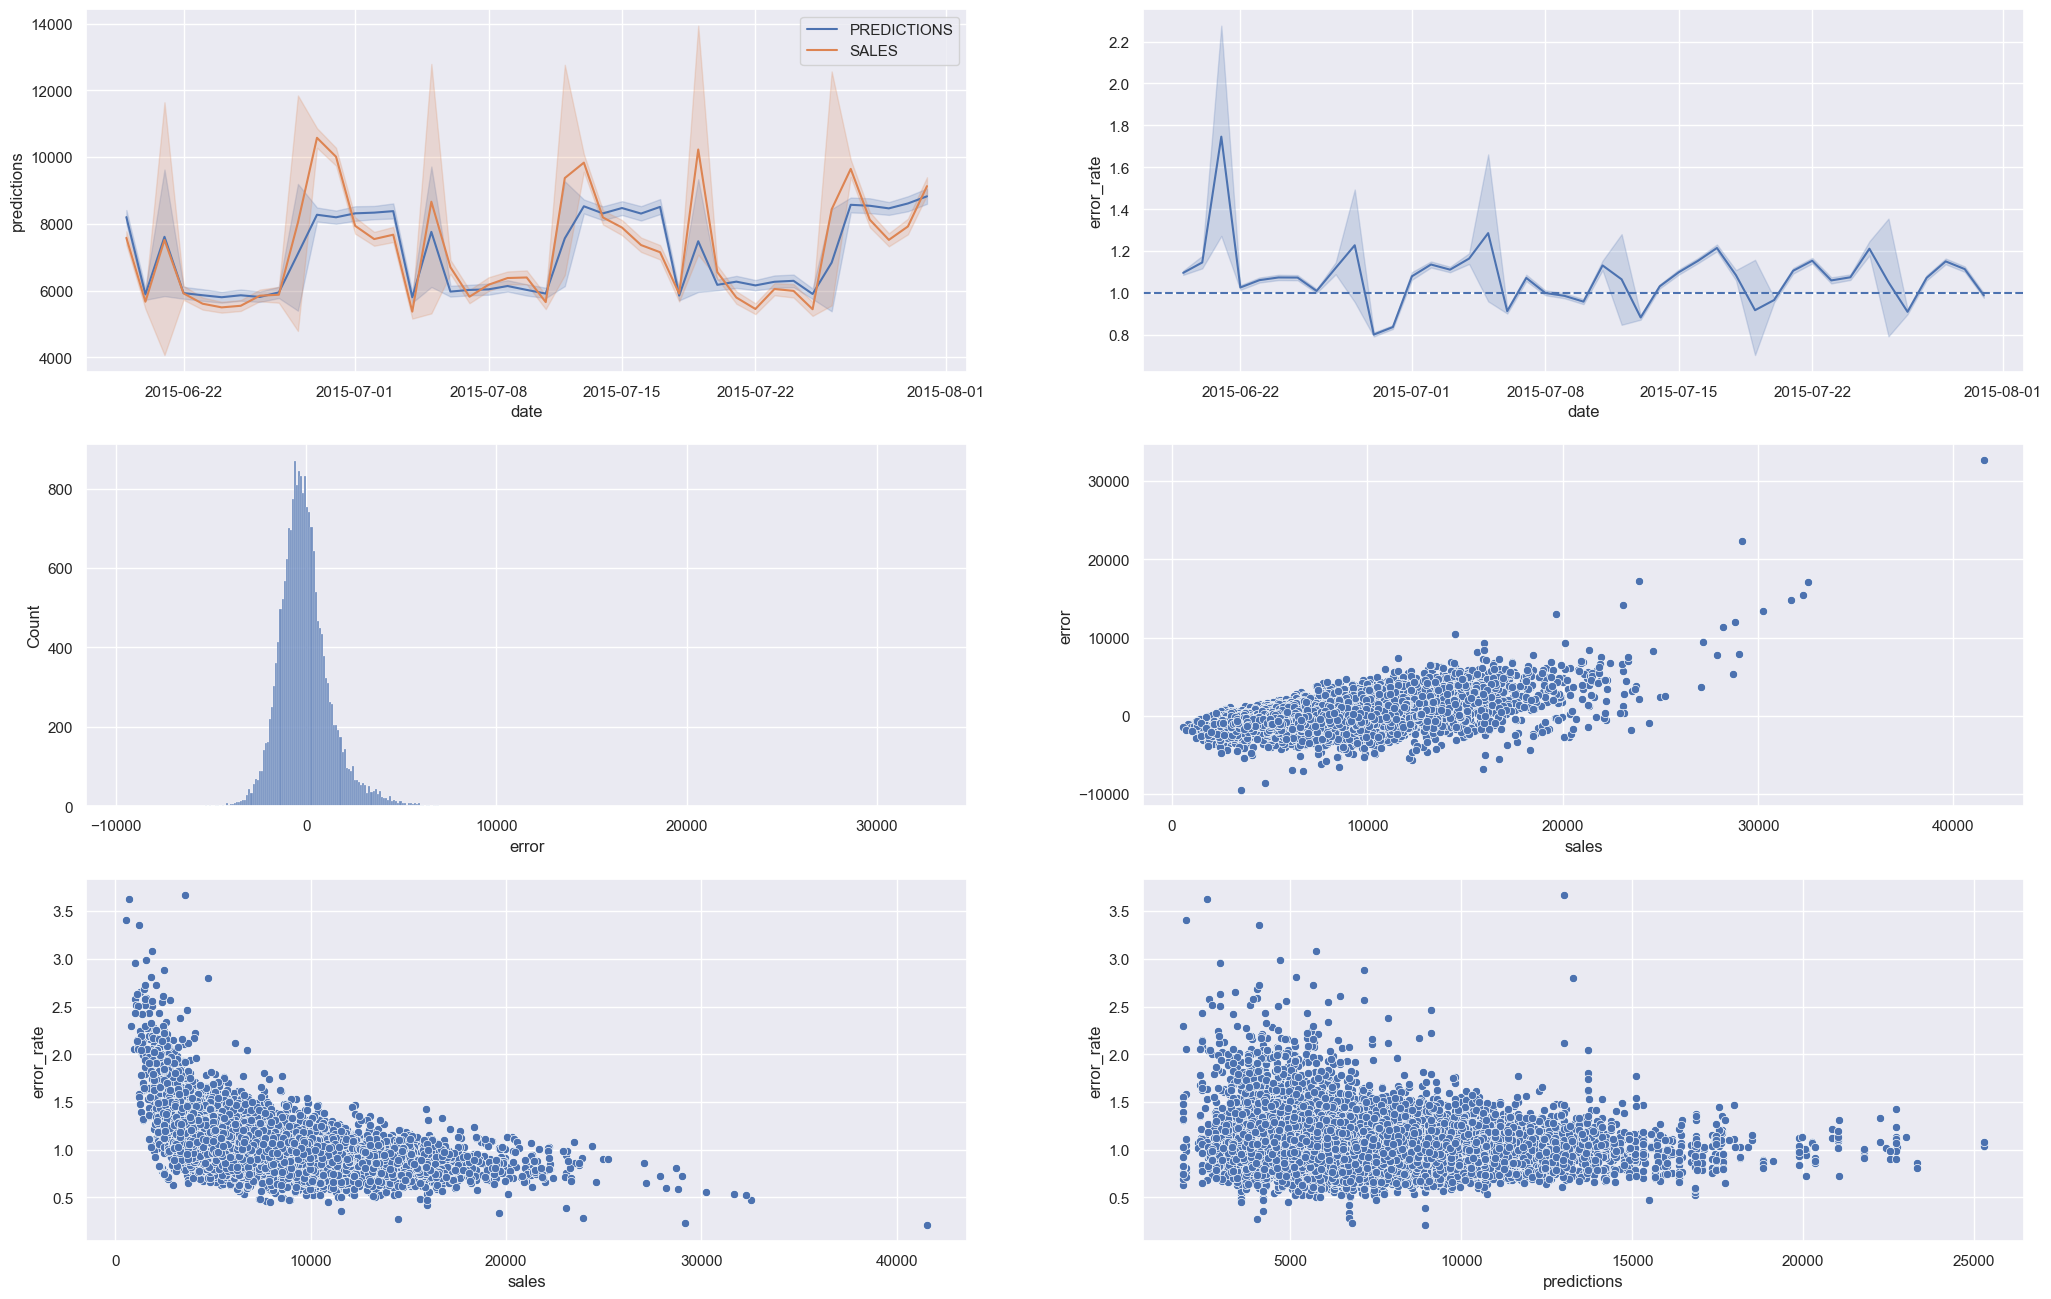

In [ ]:
## Como as minhas predições acompanham as vendas ao longo do tempo?
plt.subplot(3,2,1)
sns.lineplot(df9,  x = 'date', y = 'predictions', label = 'PREDICTIONS')
sns.lineplot(df9,  x = 'date', y = 'sales', label = 'SALES')

## Como esta se comportando o modelo em relação a superestimação e subestimação de valores?
plt.subplot(3,2,2)
sns.lineplot(df9,  x = 'date', y = 'error_rate')
plt.axhline(1, linestyle = '--')

## Como esta a distribuição dos erros do meu modelo
plt.subplot(3,2,3)
sns.histplot(df9['error'])

## Analise de residuo
## Como se comporta o  meu erro com relação as minhas predições?
plt.subplot(3,2,4)
sns.scatterplot(df9, x = 'sales', y = 'error')

plt.subplot(3,2,5)
sns.scatterplot(df9, x = 'sales', y = 'error_rate')

plt.subplot(3,2,6)
sns.scatterplot(df9, x = 'predictions', y = 'error_rate')

É notória a dificuldade do modelo em prever valores abaixo de 5k, e o comportamento de subestimar valores altos, o modelo pode estar enviesado em uma faixa de valores... como avaliar?

### 9.3.1 - Busca de erros por percentil

Objetivo: Entender a variação de desempenho do modelo para determinadas faixas de valores

In [ ]:
def split_percentis(df, total_percentis: int = 40):
    percentile_range = int(100/total_percentis)

    percentiles = [x for x in range(0 + percentile_range, 100+1, percentile_range)]
    
    percentile_values = {}
    percentile_values[0] = 0

    for i in percentiles:
        percentile_values[i] = df.sales.quantile(i/100)
    
    
    return percentile_values


def run_analysis_per_percentile():
    percentiles = split_percentis(df9)
    key_perentiles = list(percentiles.keys())
    
    df9_loss_percentile = []
    
    for p in range(0,len(percentiles) - 1):
        initial_value = percentiles[key_perentiles[p]]
        end_value = percentiles[key_perentiles[p + 1]]
    
    
        aux1 = df9[(df9.sales > initial_value) & (df9.sales <= end_value)]
        temp_df = {}
        
        temp_df['sales_mean'] = aux1.sales.mean()
        temp_df['error_rate'] = aux1.error_rate.mean()
        temp_df['error_rate_real'] = temp_df['error_rate'] - 1
        temp_df['error'] = aux1.error.mean()
        temp_df['percentile'] = list(percentiles.keys())[p+1]
        temp_df['registros'] = len(aux1)
    
        temp_df['faixa'] = f'>{round(initial_value,2)} and  < {round(end_value,2)}'
    
        df9_loss_percentile.append(pd.DataFrame(temp_df, index = [p]))
    
    df9_loss_percentile = pd.concat(df9_loss_percentile)
    return df9_loss_percentile

df9_loss_percentile = run_analysis_per_percentile()

df9_loss_percentile


,sales_mean,error_rate,error_rate_real,error,percentile,registros,faixa
0,2145.232446,1.681866,0.681866,-1369.936289,2,413,>0 and < 2621.6
1,2871.828087,1.356076,0.356076,-1013.267571,4,413,>2621.6 and < 3085.0
2,3240.727494,1.257203,0.257203,-833.964008,6,411,>3085.0 and < 3374.8
3,3505.748792,1.216664,0.216664,-758.926308,8,414,>3374.8 and < 3633.0
4,3741.247573,1.190204,0.190204,-710.981992,10,412,>3633.0 and < 3835.0
5,3925.526570,1.160034,0.160034,-627.642473,12,414,>3835.0 and < 4013.0
6,4098.882927,1.153183,0.153183,-627.353258,14,410,>4013.0 and < 4177.2
7,4265.024096,1.162390,0.162390,-692.243562,16,415,>4177.2 and < 4347.0
8,4428.442543,1.131104,0.131104,-580.324357,18,409,>4347.0 and < 4502.4
9,4573.921241,1.117949,0.117949,-539.523828,20,419,>4502.4 and < 4639.0


<Axes: xlabel='percentile', ylabel='error_rate_real'>

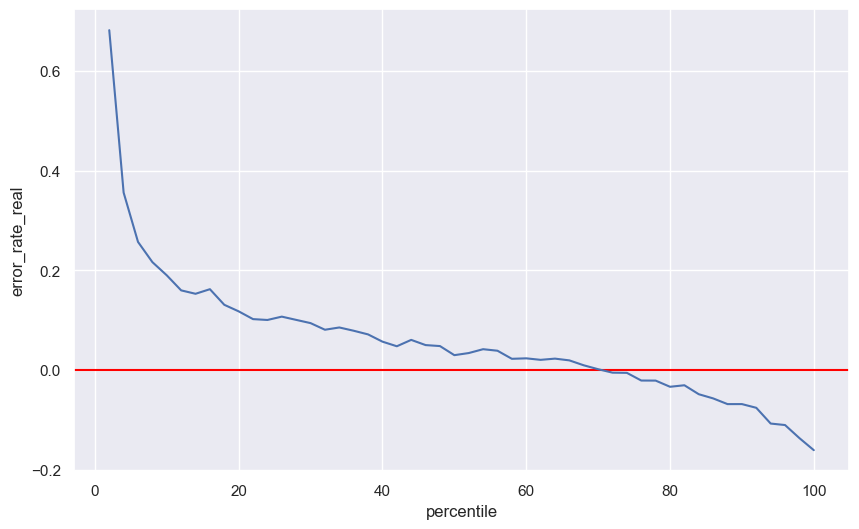

In [ ]:
plt.figure(figsize=(10,6))
plt.axhline(0, color = 'red')
sns.lineplot(df9_loss_percentile, x = 'percentile', y = 'error_rate_real')

# 10.0 - API

## 10.1 - API Definition

In [ ]:
import inflection 
import pandas as pd
import pickle as pkl
import numpy as np
import joblib as jb
import datetime 



class Data_preprocessing():
    def __init__(self, 
                 df_raw : pd.DataFrame,
                 path_scallers : str = './scallers/'):

        self.path_scallers = path_scallers
        self.df_raw = df_raw
        self._load_scallers()

        self._pipeline()
    
    
    def _pipeline(self):
        
        self.df_processing = self._data_cleaning(self.df_raw)
        self.df_processing = self._change_dtypes(self.df_processing)
        self.df_processing = self._feature_enginnering(self.df_processing)
        self.df_processing = self._feature_transformation(self.df_processing)
        self.df_gold = self._feature_selection(self.df_processing) 
        

    def _load_scallers(self):

        self.robust_scaller  =  jb.load(self.path_scallers + 'robustScaller.pkl')
        self.label_enconder  =  jb.load(self.path_scallers + 'labelEncoder.pkl')
        self.minMax_scaller  =  jb.load(self.path_scallers + 'minmaxScaller.pkl')
    
    
    def _data_cleaning(self,
                      df_step):
        

        __current_df = df_step.copy()
        raw_columns = __current_df.columns.values 

        snake_case = lambda x: inflection.underscore(x)

        new_columns = list(map(snake_case, raw_columns))
        __current_df.columns = new_columns

        __current_df.loc[:, 'date'] = pd.to_datetime(__current_df['date'])

        __current_df['date'] = pd.to_datetime(__current_df.date)

        # Assumption: Se o dado está nulo, é devido podemos considerar que ou esqueceram de anotar,
        # ou não há competidor proximo, para o segundo então o valor pode ser um valor abitrariamente alto
        # competition_distance  
        __current_df.loc[__current_df['competition_distance'].isna(), 'competition_distance'] = __current_df.competition_distance.max() * 3

        # competition_open_since_year    
        # Assumption: Aqui estamos pensando na etapa de feature enginnering 
        # onde o tempo desde que um competidor foi aberto impacta na quantidade de vendas, de modo que cria-se um regime 
        # transitorio em que a loja tem suas vendas diminuidas no inicio e posteriomente suas vendas voltam a subir
        # aqui a variavel é QUANTO TEMPO tem DESDE QUE O COMPETIDODR FOI ABERTO 
        # bem quando esta variavel for calculada para estes casos o retorno será zero. 
        # porém TUDO É CICLICO E TUDO pode mudar se necessário. 
        __current_df.loc[__current_df['competition_open_since_year'].isna(), 'competition_open_since_year'] = \
            __current_df.loc[__current_df['competition_open_since_year'].isna(), 'date'].dt.year 

        # competition_open_since_month    

        __current_df.loc[__current_df['competition_open_since_month'].isna(), 'competition_open_since_month'] = \
                __current_df.loc[__current_df['competition_open_since_month'].isna(), 'date'].dt.month 

                                
        # promo2_since_week               
        # Caso o valor seja nulo, siginifica que a loja não aderiu a promo2 
        # logo podemos usar a mesma ideia da anterior, uma vez que o "tempo nesta promoção" também será nulo
        __current_df.loc[__current_df['promo2_since_week'].isna(), 'promo2_since_week'] = \
                __current_df.loc[__current_df['promo2_since_week'].isna(), 'date'].dt.isocalendar().week 


        # promo2_since_year    
        # Caso o valor seja nulo, siginifica que a loja não aderiu a promo2 
        # logo podemos usar a mesma ideia da anterior, uma vez que o "tempo nesta promoção" também será nulo
        __current_df.loc[__current_df['promo2_since_year'].isna(), 'promo2_since_year'] = \
                __current_df.loc[__current_df['promo2_since_year'].isna(), 'date'].dt.year 
                
        # promo_interval
        # Indica os meses em que a promoção reiniciou 
        map_month = { 
            1 : 'Jan',
            2 : 'Feb',
            3 : 'Mar',
            4 : 'Apr',
            5 : 'May',
            6 : 'Jun',
            7 : 'Jul',
            8 : 'Aug',
            9 : 'Sep',
            10 : 'Oct',
            11 : 'Nov',
            12 : 'Dec',
        }
        __current_df['date_month'] = __current_df['date'].dt.month.map(map_month)
        __current_df.promo_interval.fillna("0", inplace=True)

        __current_df['is_promo'] = __current_df.apply(lambda x: 1 if x['date_month'] in str(x['promo_interval']).split(',') else 0, axis = 1)

        return __current_df

    def _change_dtypes(self, current_df : pd.DataFrame):
        __current_df = current_df.copy()
        
        current_df['competition_open_since_month'] = current_df['competition_open_since_month'].astype(int)
        current_df['competition_open_since_year'] = current_df['competition_open_since_year'].astype(int)  
        current_df['promo2_since_week'] = current_df['promo2_since_week'].astype(int) 
        current_df['promo2_since_year'] = current_df['promo2_since_year'].astype(int) 

        return current_df
    

    def _feature_enginnering(self, 
                            current_df : pd.DataFrame):

        __current_df = current_df.copy()

        # year 
        __current_df['year'] = __current_df.date.dt.year

        # month 
        __current_df['month'] = __current_df.date.dt.month 

        # day
        __current_df['day'] = __current_df.date.dt.day

        # week of year 
        __current_df['week_year'] = __current_df.date.dt.isocalendar().week

        # year-week
        __current_df['year_week'] = __current_df.date.dt.strftime('%Y-%W')

        # competition since 
        __current_df['competion_open_date_temp'] = pd.to_datetime(__current_df.apply(lambda x:  datetime.date( x['competition_open_since_year'], \
                                                                        x['competition_open_since_month'],1), axis = 1))



        __current_df['competion_since_days'] = (__current_df['date'] - __current_df['competion_open_date_temp']).dt.days 
        __current_df['competion_since_month'] = ( (__current_df['date'] - __current_df['competion_open_date_temp']).dt.days/30).astype('int') 


        # promo since


        __current_df['promo2_since_year_week_temp'] = (__current_df.apply(lambda x: str(x['promo2_since_year']) + '-' + str(x['promo2_since_week']), axis = 1))


        __current_df['promo2_since'] = __current_df['promo2_since_year_week_temp'].apply( lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days = 7))

        __current_df['promo2_time_week'] = ( ( __current_df['date'] - __current_df['promo2_since'] )/7 ).apply(lambda x: x.days ).astype( int )

        # assortment 
        assortment_map = {
            'a' : 'basic',
            'b' : 'extra',
            'c' : 'etended'
        }

        __current_df.loc[:,'assortment'] = __current_df['assortment'].apply(lambda x: assortment_map[x])

        # state holiday

        state_holiday_map = {
            'a' : 'public_holiday',
            'b' : 'easter_holiday',
            'c' : 'christmas',
            '0' : 'regular_day'
        }

        __current_df.loc[:, 'state_holiday'] = __current_df.state_holiday.apply(lambda x: state_holiday_map[x])

        return __current_df 
    

    def _feature_selection(self, 
                          current_df):

        __current_df = current_df.copy()
        cols_drop = ['customers', 'open', 'competion_open_date_temp', 'promo2_since_year_week_temp']

        __current_df = __current_df[(__current_df.open != 0) & (__current_df.sales) > 0]
        __current_df = __current_df.drop(cols_drop, axis= 1)

        cols_selected = [
            'store',
            'promo',
            'school_holiday',
            'store_type',
            'assortment',
            'competition_distance',
            'competition_open_since_year',
            'promo2',
            'promo2_since_year',
            'competion_since_month',
            'promo2_time_week'

         ]
        

        return __current_df[cols_selected]
        

    def _feature_transformation(self, current_df):
        __current_df = current_df.copy()

        continuous_data = ['competition_distance',  'competition_open_since_year',  
                           'competion_since_days',  'year','promo2_time_week']
        
        robust_scallers = ['competition_distance', 'competion_since_days', 
                           'sales', 'competion_since_month', 'promo2_since_year']
        
        outros_continuos = list(set(continuous_data) - set(robust_scallers))
        
        X = __current_df[robust_scallers].values
        __current_df[robust_scallers] =  self.robust_scaller.transform(X)

        X = __current_df[outros_continuos].values
        __current_df[outros_continuos] =  self.minMax_scaller.transform(X)


        __current_df = pd.get_dummies(__current_df, prefix = ['state_holiday'], columns = ['state_holiday'], dtype=float)
        store_type = self.label_enconder.transform(__current_df.store_type)
        __current_df.loc[:, 'store_type'] = store_type
        

        # assortment 
        # O sortimento possui uma caracteristica ordinal
        # extended > extra > basic
        dict_assortment = {
            'basic' : 0,
            'extra' : 1,
            'extended' : 2
        }
        __current_df.loc[:, 'assortment'] = __current_df.assortment.apply(lambda x: 'extended' if x == 'etended' else x)
        __current_df.loc[:, 'assortment'] = __current_df.assortment.apply(lambda x: dict_assortment[x])


        __current_df.loc[:, 'sales'] = np.log1p(__current_df.sales.values)
        

        return __current_df

## API Tester

In [58]:
import sys
from API import data_preparation
from API import model 

df_sales_raw = pd.read_csv('./Data/test.csv', low_memory=False)
df_store_raw = pd.read_csv('./Data/store.csv', low_memory=False)

df_test_raw = pd.merge(df_sales_raw, df_store_raw, on = 'Store', how = 'left')
df_test_raw = df_test_raw[df_test_raw.Open == 1]

In [59]:
df_test_raw.drop(columns=['Id'], inplace=True)
raw_columns = df_test_raw.columns.values 

snake_case = lambda x: inflection.underscore(x)

new_columns = list(map(snake_case, raw_columns))
df_test_raw.columns = new_columns


In [72]:
import requests 
import json 

url = 'http://192.168.100.40:5000/rossmann/predict'
header = {'Content-type' : 'application/json'}
data = json.dumps(df_test_raw.sample(1).to_dict(orient = 'records')) 

print(data)
r = requests.post(url, data = data, headers = header)
print(f'Status Code {r.status_code}')
print(f'O retorno foi: {r.json()}')



[{"store": 1008, "day_of_week": 2, "date": "2015-09-01", "open": 1.0, "promo": 1, "state_holiday": "0", "school_holiday": 0, "store_type": "a", "assortment": "c", "competition_distance": 30.0, "competition_open_since_month": 9.0, "competition_open_since_year": 2010.0, "promo2": 0, "promo2_since_week": NaN, "promo2_since_year": NaN, "promo_interval": NaN}]
Status Code 200
O retorno foi: [{'store': 1008, 'sales': 5863.50830078125}]
